In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage import io, measure
from scipy import ndimage
from collections import Counter
import re
import scipy.stats as stats

# Set up matplotlib for better visualization
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['figure.dpi'] = 100
plt.style.use('ggplot')

# UPDATE THESE PATHS BEFORE RUNNING
# Directory containing your cell mask .tif files
# Define your input and output directories
input_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/flow3-x20/Cell_merged_conservative"  # Your specified folder
output_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Analysis/flow3-x20/Overall/Cell"  # Your specified output folder

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Function to extract pressure value from filename
def extract_pressure(filename):
    match = re.search(r'(0Pa|1\.4Pa)', str(filename))
    if match:
        return match.group(1)
    return None

# Function to find and organize mask files by pressure
def find_mask_files(input_dir):
    pressure_dict = {'0Pa': [], '1.4Pa': []}
    files = [f for f in os.listdir(input_dir) if f.endswith('_cell_mask_merged_conservative.tif') or
                                               f.endswith('_cell_mask.tif')]
    print(f"Found {len(files)} mask files.")

    for file in files:
        pressure = extract_pressure(file)
        if pressure and pressure in pressure_dict:
            pressure_dict[pressure].append(os.path.join(input_dir, file))

    print(f"Organized files by pressure:")
    for pressure, file_list in pressure_dict.items():
        print(f"  {pressure}: {len(file_list)} files")

    return pressure_dict

# Function to load a mask image
def load_mask_image(filepath):
    try:
        img = io.imread(filepath)
        if img.dtype == bool:
            img = img.astype(np.uint8)
        if np.max(img) <= 1:
            img, num_cells = ndimage.label(img > 0)
            print(f"Converted binary mask to labeled image with {num_cells} cells")
        return img
    except Exception as e:
        print(f"Error loading {filepath}: {str(e)}")
        return None

# Function to analyze cell shapes
def analyze_cell_shapes(cell_image, simplified=True, flow_direction='horizontal'):
    # Ensure we have integer type image
    if not np.issubdtype(cell_image.dtype, np.integer):
        cell_image = cell_image.astype(np.int32)

    # Check if we need to relabel the cells
    if np.max(cell_image) < 2:
        from scipy.ndimage import label
        cell_image, num_regions = label(cell_image > 0)

    cell_props = measure.regionprops(cell_image)
    cell_metrics = []
    cell_shapes = []
    cell_contours = []

    for cell_prop in cell_props:
        cell_id = cell_prop.label

        # Skip very small objects (likely artifacts)
        if cell_prop.area < 100:
            continue

        # Create binary mask for current cell
        mask = (cell_image == cell_id).astype(np.uint8) * 255

        # Find contours
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        if not contours:
            continue

        contour = contours[0]
        cell_contours.append(contour)

        # Basic metrics from regionprops
        area = cell_prop.area
        perimeter = cell_prop.perimeter if cell_prop.perimeter else 0
        centroid_y, centroid_x = cell_prop.centroid
        orientation_rad = cell_prop.orientation  # in radians
        orientation_deg = np.degrees(orientation_rad) % 180  # 0-180°
        major_axis_length = cell_prop.major_axis_length
        minor_axis_length = cell_prop.minor_axis_length
        eccentricity = cell_prop.eccentricity

        # Calculate alignment with flow (0° = aligned, 90° = perpendicular)
        if flow_direction == 'horizontal':
            flow_alignment = np.minimum(orientation_deg, 180 - orientation_deg)
        else:  # vertical
            flow_alignment = 90 - np.abs(90 - orientation_deg)

        # Additional shape metrics
        circularity = (4 * np.pi * area) / (perimeter * perimeter) if perimeter > 0 else 0
        solidity = cell_prop.solidity
        elongation = major_axis_length / minor_axis_length if minor_axis_length > 0 else 0

        # Shape classification
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
        vertices = len(approx)

        if simplified:
            # Simplified shape classification
            if circularity > 0.8:
                shape = "circular"
            elif elongation > 2.5:
                shape = "elongated"
            elif vertices >= 5:
                shape = "polygonal"
            else:
                shape = "irregular"
        else:
            # More detailed classification
            if circularity > 0.85:
                shape = "circular"
            elif elongation > 3.0:
                shape = "elongated"
            elif vertices >= 7:
                shape = "multi-sided"
            else:
                shape = "irregular"

        cell_shapes.append(shape)

        # Categorize alignment
        if flow_alignment < 20:
            alignment_category = "aligned"
        elif flow_alignment > 70:
            alignment_category = "perpendicular"
        else:
            alignment_category = "intermediate"

        # Store metrics
        metrics = {
            'cell_id': cell_id,
            'area': area,
            'perimeter': perimeter,
            'centroid_x': centroid_x,
            'centroid_y': centroid_y,
            'orientation_deg': orientation_deg,
            'orientation_rad': orientation_rad,
            'flow_alignment': flow_alignment,
            'major_axis_length': major_axis_length,
            'minor_axis_length': minor_axis_length,
            'eccentricity': eccentricity,
            'circularity': circularity,
            'solidity': solidity,
            'elongation': elongation,
            'shape': shape,
            'alignment_category': alignment_category
        }

        cell_metrics.append(metrics)

    # Summary statistics
    shape_distribution = Counter(cell_shapes)
    alignment_distribution = Counter([m['alignment_category'] for m in cell_metrics])
    total_cells = len(cell_shapes)

    results = {
        'all_metrics': cell_metrics,
        'shape_distribution': shape_distribution,
        'alignment_distribution': alignment_distribution,
        'total_cells': total_cells,
        'cell_contours': cell_contours
    }

    return results

# Function to process all files for a specific pressure
def process_pressure_group(file_list, pressure_name, simplified=True, flow_direction='horizontal'):
    print(f"\n=== Processing {pressure_name} group with {len(file_list)} files ===")

    all_cell_metrics = []
    combined_shape_distribution = Counter()
    combined_alignment_distribution = Counter()
    total_cells_analyzed = 0

    for file_path in file_list:
        file_name = os.path.basename(file_path)
        print(f"\nProcessing file: {file_name}")

        # Load mask image
        cell_img = load_mask_image(file_path)

        if cell_img is None:
            print(f"Skipping file due to loading error: {file_name}")
            continue

        # Analyze cell shapes
        try:
            shape_results = analyze_cell_shapes(cell_img, simplified, flow_direction)

            # Add file identifier to metrics
            for metrics in shape_results['all_metrics']:
                metrics['file_name'] = file_name
                metrics['pressure'] = pressure_name
                all_cell_metrics.append(metrics)

            # Update combined statistics
            combined_shape_distribution.update(shape_results['shape_distribution'])
            combined_alignment_distribution.update(shape_results['alignment_distribution'])
            total_cells_analyzed += shape_results['total_cells']

            print(f"Analyzed {shape_results['total_cells']} cells from {file_name}")

        except Exception as e:
            print(f"Error during analysis of {file_name}: {str(e)}")
            import traceback
            traceback.print_exc()

    # Create results
    results = {
        'pressure': pressure_name,
        'total_files': len(file_list),
        'total_cells': total_cells_analyzed,
        'all_cell_metrics': all_cell_metrics,
        'shape_distribution': dict(combined_shape_distribution),
        'alignment_distribution': dict(combined_alignment_distribution)
    }

    # Create dataframe
    if all_cell_metrics:
        results['metrics_df'] = pd.DataFrame(all_cell_metrics)

    return results

# Function to visualize cell orientations
def visualize_cell_orientations(cell_image, metrics, output_path=None, title=None):
    # Create a visualization image (RGB)
    vis_img = np.zeros((*cell_image.shape, 3), dtype=np.uint8)

    # Create a cell ID to metrics mapping
    cell_metrics_map = {m['cell_id']: m for m in metrics}

    # Get alignment categories for all cells
    alignment_categories = {m['cell_id']: m['alignment_category'] for m in metrics}

    # Define colors for alignment categories
    alignment_colors = {
        'aligned': (0, 255, 0),       # Green for aligned
        'perpendicular': (255, 0, 0), # Red for perpendicular
        'intermediate': (0, 0, 255)   # Blue for intermediate
    }

    # Color each cell based on its alignment category
    for cell_id in np.unique(cell_image):
        if cell_id == 0:  # Skip background
            continue

        if cell_id not in cell_metrics_map:
            continue

        # Get cell mask
        mask = cell_image == cell_id

        # Get alignment category
        alignment = alignment_categories.get(cell_id, 'intermediate')

        # Apply color based on alignment
        color = alignment_colors[alignment]
        for i in range(3):
            vis_img[mask, i] = color[i]

    # Display the visualization
    plt.figure(figsize=(12, 10))
    plt.imshow(vis_img)

    if title:
        plt.title(title)
    else:
        plt.title('Cell Orientation Visualization')

    plt.axis('off')

    # Add a legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='green', edgecolor='black', label='Aligned with flow'),
        Patch(facecolor='blue', edgecolor='black', label='Intermediate'),
        Patch(facecolor='red', edgecolor='black', label='Perpendicular to flow')
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    # Save the figure if output path is provided
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Saved orientation visualization to {output_path}")

    plt.close()

# Function to create rose plot of cell orientations
def create_orientation_rose_plot(metrics_df, output_path=None, title=None):
    # Extract orientation data
    orientations = metrics_df['orientation_deg'].values

    # Convert to radians for plotting
    orientation_rad = np.radians(orientations)

    # Create figure
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='polar')

    # Define bins (0-180 degrees, in 10-degree increments)
    bins = np.linspace(0, np.pi, 19)  # 18 bins (10 degrees each)

    # Create histogram
    hist, bin_edges = np.histogram(orientation_rad, bins=bins)

    # Plot rose diagram
    width = np.pi / 18
    bars = ax.bar(bin_edges[:-1], hist, width=width, bottom=0.0, alpha=0.7)

    # Color bars based on alignment with flow
    for i, bar in enumerate(bars):
        # Calculate angle in degrees
        angle_deg = np.degrees(bin_edges[i])

        # Calculate alignment with flow (0 = aligned, 90 = perpendicular)
        alignment = min(angle_deg, 180 - angle_deg)

        # Normalized alignment (0 = aligned = green, 1 = perpendicular = red)
        norm_alignment = alignment / 90

        # Set color
        if norm_alignment < 0.33:
            color = (0, 1, 0)  # Green
        elif norm_alignment < 0.66:
            color = (1, 1, 0)  # Yellow
        else:
            color = (1, 0, 0)  # Red

        bar.set_facecolor(color)

    # Set up polar plot
    ax.set_theta_zero_location("N")  # Set 0 degrees at the top
    ax.set_theta_direction(-1)  # Go clockwise
    ax.set_thetamin(0)
    ax.set_thetamax(180)

    # Custom labels for degrees
    ax.set_thetagrids(np.arange(0, 181, 30), np.arange(0, 181, 30))

    if title:
        ax.set_title(title, y=1.1)
    else:
        ax.set_title("Cell Orientation Rose Diagram", y=1.1)

    # Add reference lines
    ax.axvline(x=0, color='green', linestyle='--', alpha=0.7, linewidth=2)
    ax.axvline(x=np.pi/2, color='red', linestyle='--', alpha=0.7, linewidth=2)

    # Save figure if output path is provided
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Saved orientation rose plot to {output_path}")

    plt.close()

# Function to compare pressure groups
def compare_pressure_groups(pressure_results, output_dir):
    # Create output directory for comparison
    comparison_dir = os.path.join(output_dir, "pressure_comparison")
    os.makedirs(comparison_dir, exist_ok=True)

    # Extract pressure names
    pressure_names = list(pressure_results.keys())

    # Create a combined dataframe
    all_metrics_df = pd.concat([pressure_results[p]['metrics_df'] for p in pressure_names])

    # Save combined metrics
    all_metrics_df.to_csv(os.path.join(comparison_dir, "all_cell_metrics.csv"), index=False)

    # 1. Compare shape distributions
    plt.figure(figsize=(12, 6))

    # Prepare data for plotting
    shape_data = []

    for pressure in pressure_names:
        df = pressure_results[pressure]['metrics_df']
        shape_counts = df['shape'].value_counts(normalize=True) * 100

        for shape, percentage in shape_counts.items():
            shape_data.append({
                'Pressure': pressure,
                'Shape': shape,
                'Percentage': percentage
            })

    # Create and plot dataframe
    shape_df = pd.DataFrame(shape_data)
    sns.barplot(x='Shape', y='Percentage', hue='Pressure', data=shape_df)

    plt.title('Cell Shape Distribution by Pressure')
    plt.xlabel('Cell Shape')
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.legend(title='Pressure')
    plt.tight_layout()

    # Save figure
    plt.savefig(os.path.join(comparison_dir, "shape_distribution_comparison.png"), dpi=300)
    plt.close()

    # 2. Compare alignment distributions
    plt.figure(figsize=(10, 6))

    # Prepare data for plotting
    alignment_data = []

    for pressure in pressure_names:
        df = pressure_results[pressure]['metrics_df']
        alignment_counts = df['alignment_category'].value_counts(normalize=True) * 100

        for category, percentage in alignment_counts.items():
            alignment_data.append({
                'Pressure': pressure,
                'Alignment': category,
                'Percentage': percentage
            })

    # Create and plot dataframe
    alignment_df = pd.DataFrame(alignment_data)
    sns.barplot(x='Alignment', y='Percentage', hue='Pressure', data=alignment_df)

    plt.title('Cell Alignment Distribution by Pressure')
    plt.xlabel('Alignment Category')
    plt.ylabel('Percentage (%)')
    plt.legend(title='Pressure')
    plt.tight_layout()

    # Save figure
    plt.savefig(os.path.join(comparison_dir, "alignment_distribution_comparison.png"), dpi=300)
    plt.close()

    # 3. Compare flow alignment with box plot
    plt.figure(figsize=(8, 6))

    # Create box plot
    sns.boxplot(x='pressure', y='flow_alignment', data=all_metrics_df)

    plt.title('Flow Alignment Comparison by Pressure')
    plt.xlabel('Pressure')
    plt.ylabel('Alignment with Flow (degrees)')
    plt.grid(True, alpha=0.3)

    # Perform statistical test
    group1 = all_metrics_df[all_metrics_df['pressure'] == pressure_names[0]]['flow_alignment']
    group2 = all_metrics_df[all_metrics_df['pressure'] == pressure_names[1]]['flow_alignment']

    if len(group1) > 0 and len(group2) > 0:
        # Mann-Whitney U test
        stat, p_value = stats.mannwhitneyu(group1, group2)
        plt.annotate(f'p-value: {p_value:.4f}', xy=(0.5, 0.95), xycoords='axes fraction',
                     ha='center', bbox=dict(boxstyle='round', fc='white', alpha=0.8))

    plt.tight_layout()
    plt.savefig(os.path.join(comparison_dir, "flow_alignment_boxplot.png"), dpi=300)
    plt.close()

    # 4. Create summary statistics table
    summary_data = []

    for pressure in pressure_names:
        df = pressure_results[pressure]['metrics_df']

        row = {
            'Pressure': pressure,
            'Total Cells': len(df),
            'Mean Flow Alignment (degrees)': df['flow_alignment'].mean(),
            'Aligned Cells (%)': (df['alignment_category'] == 'aligned').mean() * 100,
            'Perpendicular Cells (%)': (df['alignment_category'] == 'perpendicular').mean() * 100,
            'Circular Cells (%)': (df['shape'] == 'circular').mean() * 100,
            'Elongated Cells (%)': (df['shape'] == 'elongated').mean() * 100,
            'Polygonal Cells (%)': (df['shape'] == 'polygonal').mean() * 100
        }

        summary_data.append(row)

    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv(os.path.join(comparison_dir, "pressure_comparison_summary.csv"), index=False)

    print(f"\nComparison results saved to {comparison_dir}")
    print("\nSummary Statistics:")
    print(summary_df)

    return summary_df

# Main function
def main():
    print("Starting cell orientation analysis...")

    # Find and organize files by pressure
    pressure_dict = find_mask_files(input_dir)

    # Process each pressure group
    pressure_results = {}

    for pressure, file_list in pressure_dict.items():
        if file_list:
            # Process with simplified categories and horizontal flow direction
            results = process_pressure_group(file_list, pressure)
            pressure_results[pressure] = results

            # Create pressure-specific output directory
            pressure_dir = os.path.join(output_dir, f"pressure_{pressure}")
            os.makedirs(pressure_dir, exist_ok=True)

            # Save metrics to CSV
            if 'metrics_df' in results:
                results['metrics_df'].to_csv(os.path.join(pressure_dir, f"{pressure}_cell_metrics.csv"), index=False)

            # Create orientation rose plot
            if 'metrics_df' in results:
                rose_output = os.path.join(pressure_dir, f"{pressure}_orientation_rose.png")
                create_orientation_rose_plot(
                    results['metrics_df'],
                    output_path=rose_output,
                    title=f"{pressure}: Cell Orientation Distribution"
                )

                # Create visualization for first image
                if file_list:
                    sample_img = load_mask_image(file_list[0])
                    if sample_img is not None:
                        sample_results = analyze_cell_shapes(sample_img)

                        vis_output = os.path.join(pressure_dir, f"{pressure}_orientation_visualization.png")
                        visualize_cell_orientations(
                            sample_img,
                            sample_results['all_metrics'],
                            output_path=vis_output,
                            title=f"{pressure}: Cell Orientation Visualization"
                        )

    # Compare pressure groups
    if len(pressure_results) >= 2:
        summary_df = compare_pressure_groups(pressure_results, output_dir)
    else:
        print("\nNot enough pressure groups for comparison")

    print("\nCell orientation analysis completed!")

# Run the main function
if __name__ == "__main__":
    main()

Starting cell orientation analysis...
Found 8 mask files.
Organized files by pressure:
  0Pa: 3 files
  1.4Pa: 5 files

=== Processing 0Pa group with 3 files ===

Processing file: 0Pa_U_05mar19_20x_L2RA_Flat_seq001_cell_mask_merged_conservative.tif
Analyzed 329 cells from 0Pa_U_05mar19_20x_L2RA_Flat_seq001_cell_mask_merged_conservative.tif

Processing file: 0Pa_U_05mar19_20x_L2RA_Flat_seq002_cell_mask_merged_conservative.tif
Analyzed 368 cells from 0Pa_U_05mar19_20x_L2RA_Flat_seq002_cell_mask_merged_conservative.tif

Processing file: 0Pa_U_05mar19_20x_L2RA_Flat_seq003_cell_mask_merged_conservative.tif
Analyzed 385 cells from 0Pa_U_05mar19_20x_L2RA_Flat_seq003_cell_mask_merged_conservative.tif
Saved orientation rose plot to /content/drive/MyDrive/knowledge/University/Master/Thesis/Analysis/flow3-x20/Overall/Cell/pressure_0Pa/0Pa_orientation_rose.png
Saved orientation visualization to /content/drive/MyDrive/knowledge/University/Master/Thesis/Analysis/flow3-x20/Overall/Cell/pressure_0Pa/0

cell shape

Cell shape

In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import cv2
from pathlib import Path
from scipy.spatial import Voronoi
from skimage import measure, io
import tifffile
import re
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from collections import defaultdict

# Path configuration
input_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/flow3-x20/Cell_merged_conservative"
output_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Analysis/flow3-x20/Overall/Cell"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Function to find all mask files and group by pressure
def find_mask_files(base_dir):
    """
    Find all cell mask files and categorize by pressure condition.

    Returns:
        dict: Dictionary with pressure conditions as keys and lists of file paths as values
    """
    pressure_groups = defaultdict(list)

    # Pattern to extract pressure from filename
    pattern = r"^([\d\.]+Pa)_.*_cell_mask_merged_conservative\.tif$"

    for filename in os.listdir(base_dir):
        if filename.endswith("_cell_mask_merged_conservative.tif"):
            match = re.match(pattern, filename)
            if match:
                pressure = match.group(1)
                file_path = os.path.join(base_dir, filename)
                pressure_groups[pressure].append(file_path)

    return pressure_groups

# Voronoi regularization function
def voronoi_regularize_cells(cell_mask, min_area=100, boundary_buffer=5, visualize=False):
    """
    Regularize cell shapes using Voronoi diagrams.
    """
    # Ensure cell_mask is integer type
    if not np.issubdtype(cell_mask.dtype, np.integer):
        print(f"Converting cell_mask to int32, original dtype: {cell_mask.dtype}")
        cell_mask = cell_mask.astype(np.int32)

    # Get image dimensions
    h, w = cell_mask.shape

    # Extract cell properties
    cell_props = measure.regionprops(cell_mask)

    # Collect centroids for Voronoi computation
    centroids = []
    cell_ids = []

    for prop in cell_props:
        # Skip small objects
        if prop.area < min_area:
            continue

        cell_ids.append(prop.label)
        y, x = prop.centroid
        centroids.append([x, y])

    if len(centroids) == 0:
        print("No valid cells found! Check your mask or reduce min_area.")
        return cell_mask, {}

    # Add boundary points to constrain Voronoi diagram
    # These will be removed later
    boundary_points = []
    boundary_ids = []

    # Top and bottom boundaries
    for x in range(0, w, boundary_buffer):
        boundary_points.append([x, -boundary_buffer])
        boundary_points.append([x, h+boundary_buffer])
        boundary_ids.extend([-1, -1])

    # Left and right boundaries
    for y in range(0, h, boundary_buffer):
        boundary_points.append([-boundary_buffer, y])
        boundary_points.append([w+boundary_buffer, y])
        boundary_ids.extend([-1, -1])

    # Combine cell centroids with boundary points
    all_points = np.array(centroids + boundary_points)
    all_ids = cell_ids + boundary_ids

    # Compute Voronoi diagram
    try:
        vor = Voronoi(all_points)
    except Exception as e:
        print(f"Voronoi computation failed: {e}")
        print(f"Number of points: {len(all_points)}")
        return cell_mask, {}

    # Create a new mask for Voronoi-regularized cells
    voronoi_mask = np.zeros((h, w), dtype=np.int32)

    # Create mapping between original cell IDs and Voronoi cell IDs
    cell_mapping = {}

    # Print some debug info about the Voronoi structure
    print(f"Voronoi diagram has {len(vor.regions)} regions")
    print(f"Voronoi point_region shape: {vor.point_region.shape}")

    # Draw each Voronoi region for each cell
    for i in range(len(cell_ids)):  # Only iterate through valid cell points (not boundary)
        # Get the region index for this point
        point_region_idx = vor.point_region[i]

        # Skip boundary points
        if i >= len(cell_ids):
            continue

        original_cell_id = all_ids[i]

        # Skip boundary cells
        if original_cell_id < 0:
            continue

        # Get the region vertices
        region = vor.regions[point_region_idx]

        # Skip open regions or degenerate cases
        if -1 in region or len(region) < 3:
            continue

        # Get the vertex coordinates
        vertices = np.array([vor.vertices[v] for v in region])

        # Clip to image boundaries
        vertices[:, 0] = np.clip(vertices[:, 0], 0, w-1)
        vertices[:, 1] = np.clip(vertices[:, 1], 0, h-1)

        # Convert to integer coordinates for drawing
        vertices_int = vertices.astype(np.int32)

        # Create mask for this Voronoi cell
        cell_region = np.zeros((h, w), dtype=np.uint8)
        cv2.fillPoly(cell_region, [vertices_int], 1)

        # Find the intersection with the original cell
        original_cell = (cell_mask == original_cell_id).astype(np.uint8)
        intersection = cv2.bitwise_and(cell_region, original_cell)

        # Only keep the Voronoi cell if it significantly overlaps with the original cell
        if np.sum(intersection) > 0.5 * np.sum(original_cell):
            # New cell ID (i+1 to avoid 0, which is background)
            new_cell_id = i + 1

            # Add this cell to the Voronoi mask
            voronoi_mask[cell_region > 0] = new_cell_id

            # Record the mapping
            cell_mapping[original_cell_id] = new_cell_id

    # Visualization
    if visualize:
        # Create RGB visualization
        original_rgb = np.zeros((h, w, 3), dtype=np.uint8)
        voronoi_rgb = np.zeros((h, w, 3), dtype=np.uint8)

        # Generate random colors for each cell
        np.random.seed(42)  # For reproducibility
        max_id = max(np.max(cell_mask), np.max(voronoi_mask)) + 1
        colors = np.random.randint(50, 200, (max_id, 3), dtype=np.uint8)
        colors[0] = [0, 0, 0]  # Background is black

        # Color each cell in the original mask
        for i in range(1, np.max(cell_mask)+1):
            mask = (cell_mask == i)
            for c in range(3):
                original_rgb[mask, c] = colors[i % len(colors), c]

        # Color each cell in the Voronoi mask
        for i in range(1, np.max(voronoi_mask)+1):
            mask = (voronoi_mask == i)
            for c in range(3):
                voronoi_rgb[mask, c] = colors[i % len(colors), c]

        # Plot results
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        axes[0].imshow(original_rgb)
        axes[0].set_title('Original Cell Mask')
        axes[0].axis('off')

        axes[1].imshow(voronoi_rgb)
        axes[1].set_title('Voronoi Regularized Mask')
        axes[1].axis('off')

        # Draw Voronoi diagram with centroids
        axes[2].imshow(np.zeros((h, w, 3), dtype=np.uint8), extent=(0, w, 0, h))

        # Plot cell centroids (just use the original centroids)
        centroids_array = np.array(centroids)
        if len(centroids_array) > 0:  # Make sure we have centroids to plot
            axes[2].plot(centroids_array[:, 0], centroids_array[:, 1], 'r.', markersize=8)

        # Plot Voronoi edges (only those within the image)
        for simplex in vor.ridge_vertices:
            simplex = np.asarray(simplex)
            if np.all(simplex >= 0):  # Only plot finite ridges
                vertices = vor.vertices[simplex]
                # Check if edge is within image
                if (np.all(vertices[:, 0] >= 0) and np.all(vertices[:, 0] < w) and
                    np.all(vertices[:, 1] >= 0) and np.all(vertices[:, 1] < h)):
                    axes[2].plot(vertices[:, 0], vertices[:, 1], 'b-')

        axes[2].set_xlim(0, w)
        axes[2].set_ylim(0, h)
        axes[2].invert_yaxis()  # To match image coordinates
        axes[2].set_title('Voronoi Diagram with Centroids')

        plt.tight_layout()
        plt.show()

    print(f"Created Voronoi mask with {len(cell_mapping)} cells (original had {len(cell_ids)} cells)")
    return voronoi_mask, cell_mapping

# Function to classify cell shapes based on their properties
def classify_shape(vertices, circularity, elongation, solidity, convexity):
    """
    Classify cell shape based on geometric properties.
    """
    # Start with a simple classification based on circularity and elongation
    if circularity > 0.85:
        return "Circular"
    elif elongation > 2.5:
        return "Elongated"
    elif vertices >= 6 and solidity > 0.9:
        return "Hexagonal"
    elif vertices == 5 and solidity > 0.9:
        return "Pentagonal"
    elif vertices == 4 and solidity > 0.9:
        return "Rectangular"
    elif vertices <= 3 and solidity > 0.9:
        return "Triangular"
    else:
        return "Irregular"

# Function to extract cell shape metrics
def extract_cell_metrics(label_mask, min_area=100):
    """
    Extract metrics from labeled cell mask.
    """
    # Ensure mask is integer type
    if not np.issubdtype(label_mask.dtype, np.integer):
        label_mask = label_mask.astype(np.int32)

    all_metrics = []
    shape_distribution = defaultdict(int)

    # Get region properties
    props = measure.regionprops(label_mask)

    for prop in props:
        # Skip small objects
        if prop.area < min_area:
            continue

        # Get cell binary mask
        cell_mask = (label_mask == prop.label).astype(np.uint8)

        # Find contour for perimeter calculation
        contours, _ = cv2.findContours(cell_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            continue

        contour = max(contours, key=cv2.contourArea)
        perimeter = cv2.arcLength(contour, True)

        # Calculate shape metrics
        area = prop.area
        circularity = (4 * np.pi * area) / (perimeter**2) if perimeter > 0 else 0
        elongation = prop.major_axis_length / prop.minor_axis_length if prop.minor_axis_length > 0 else 1

        # Calculate orientation (0-90 degrees, where 0 is horizontal)
        orientation = np.degrees(prop.orientation) % 180
        if orientation > 90:
            orientation = 180 - orientation

        # Approximate contour to count vertices
        epsilon = 0.02 * perimeter
        approx = cv2.approxPolyDP(contour, epsilon, True)
        vertices = len(approx)

        # Classify shape
        shape = classify_shape(vertices, circularity, elongation, prop.solidity, prop.solidity)
        shape_distribution[shape] += 1

        # Store metrics
        metrics = {
            'cell_id': prop.label,
            'area': area,
            'perimeter': perimeter,
            'circularity': circularity,
            'elongation': elongation,
            'orientation': orientation,
            'vertices': vertices,
            'shape': shape,
            'solidity': prop.solidity,
            'eccentricity': prop.eccentricity
        }

        all_metrics.append(metrics)

    return {
        'all_metrics': all_metrics,
        'shape_distribution': dict(shape_distribution),
        'total_cells': len(all_metrics)
    }

# Function to analyze and compare original vs Voronoi regularized cells
def compare_original_vs_voronoi(original_mask, voronoi_mask, cell_mapping, output_path=None):
    """
    Compare metrics between original and Voronoi-regularized cell masks.
    """
    # Extract metrics for both masks
    original_results = extract_cell_metrics(original_mask)
    voronoi_results = extract_cell_metrics(voronoi_mask)

    # Create mapping dictionaries for quick access
    original_metrics = {metrics['cell_id']: metrics for metrics in original_results['all_metrics']}
    voronoi_metrics = {metrics['cell_id']: metrics for metrics in voronoi_results['all_metrics']}

    # Build comparison data
    comparison_data = []

    for orig_id, vor_id in cell_mapping.items():
        if orig_id in original_metrics and vor_id in voronoi_metrics:
            orig = original_metrics[orig_id]
            vor = voronoi_metrics[vor_id]

            comparison_data.append({
                'original_id': orig_id,
                'voronoi_id': vor_id,
                'original_area': orig['area'],
                'voronoi_area': vor['area'],
                'original_perimeter': orig['perimeter'],
                'voronoi_perimeter': vor['perimeter'],
                'original_circularity': orig['circularity'],
                'voronoi_circularity': vor['circularity'],
                'original_elongation': orig['elongation'],
                'voronoi_elongation': vor['elongation'],
                'original_orientation': orig['orientation'],
                'voronoi_orientation': vor['orientation'],
                'original_vertices': orig['vertices'],
                'voronoi_vertices': vor['vertices'],
                'original_shape': orig['shape'],
                'voronoi_shape': vor['shape'],
                'original_solidity': orig['solidity'],
                'voronoi_solidity': vor['solidity']
            })

    # Create comparison DataFrame
    if comparison_data:
        df = pd.DataFrame(comparison_data)

        # Calculate shape change statistics
        shape_changed = sum(1 for i, row in df.iterrows() if row['original_shape'] != row['voronoi_shape'])
        shape_change_pct = (shape_changed / len(df)) * 100 if len(df) > 0 else 0

        # Calculate orientation change statistics
        df['orientation_diff'] = np.abs(df['voronoi_orientation'] - df['original_orientation'])
        orientation_changed = sum(1 for i, row in df.iterrows() if row['orientation_diff'] > 15)
        orientation_change_pct = (orientation_changed / len(df)) * 100 if len(df) > 0 else 0

        # Calculate mean changes in metrics
        mean_changes = {
            'mean_area_change': (df['voronoi_area'] - df['original_area']).mean(),
            'mean_perimeter_change': (df['voronoi_perimeter'] - df['original_perimeter']).mean(),
            'mean_circularity_change': (df['voronoi_circularity'] - df['original_circularity']).mean(),
            'mean_elongation_change': (df['voronoi_elongation'] - df['original_elongation']).mean(),
            'mean_orientation_change': df['orientation_diff'].mean(),
            'mean_vertices_change': (df['voronoi_vertices'] - df['original_vertices']).mean(),
        }

        # Create shape transition matrix
        shape_transition = pd.crosstab(df['original_shape'], df['voronoi_shape'])

        # Save results if path is provided
        if output_path:
            df.to_csv(output_path + '_comparison.csv', index=False)
            shape_transition.to_csv(output_path + '_shape_transition.csv')

            # Create and save summary
            summary = {
                'total_cells': len(df),
                'shape_changed': shape_changed,
                'shape_change_pct': shape_change_pct,
                'orientation_changed': orientation_changed,
                'orientation_change_pct': orientation_change_pct,
                **mean_changes,
                'original_total_cells': original_results['total_cells'],
                'voronoi_total_cells': voronoi_results['total_cells'],
            }

            # Add shape distributions
            for shape, count in original_results['shape_distribution'].items():
                summary[f'original_{shape}_count'] = count

            for shape, count in voronoi_results['shape_distribution'].items():
                summary[f'voronoi_{shape}_count'] = count

            pd.DataFrame([summary]).to_csv(output_path + '_summary.csv', index=False)

        # Visualize changes
        visualize_shape_comparison(df, original_results['shape_distribution'],
                                  voronoi_results['shape_distribution'],
                                  output_path)

        # Return all results
        return {
            'comparison_df': df,
            'shape_change_pct': shape_change_pct,
            'orientation_change_pct': orientation_change_pct,
            'mean_changes': mean_changes,
            'shape_transition': shape_transition,
            'original_shape_distribution': original_results['shape_distribution'],
            'voronoi_shape_distribution': voronoi_results['shape_distribution'],
            'original_metrics_df': pd.DataFrame(original_results['all_metrics']),
            'voronoi_metrics_df': pd.DataFrame(voronoi_results['all_metrics'])
        }
    else:
        print("No valid cell comparisons found.")
        return None

# Function to visualize shape comparison results
def visualize_shape_comparison(df, original_shapes, voronoi_shapes, output_path=None):
    """
    Create visualizations comparing shape distributions and metrics.
    """
    # Set up the visualization
    fig, axes = plt.subplots(2, 2, figsize=(18, 16))

    # 1. Compare shape distributions (top-left)
    shape_types = sorted(set(list(original_shapes.keys()) + list(voronoi_shapes.keys())))
    shape_counts = {
        'Original': [original_shapes.get(shape, 0) for shape in shape_types],
        'Voronoi': [voronoi_shapes.get(shape, 0) for shape in shape_types]
    }
    shape_df = pd.DataFrame(shape_counts, index=shape_types)

    # Calculate percentages
    total_original = sum(shape_counts['Original'])
    total_voronoi = sum(shape_counts['Voronoi'])

    shape_df['Original %'] = shape_df['Original'] / total_original * 100 if total_original > 0 else 0
    shape_df['Voronoi %'] = shape_df['Voronoi'] / total_voronoi * 100 if total_voronoi > 0 else 0

    # Plot as grouped bar chart
    shape_df[['Original %', 'Voronoi %']].plot(kind='bar', ax=axes[0, 0])
    axes[0, 0].set_title('Shape Distribution Comparison')
    axes[0, 0].set_ylabel('Percentage of Cells')
    axes[0, 0].set_xlabel('Cell Shape')
    axes[0, 0].grid(axis='y', alpha=0.3)

    # Add percentage labels
    for i, p in enumerate(axes[0, 0].patches):
        axes[0, 0].annotate(f"{p.get_height():.1f}%",
                          (p.get_x() + p.get_width()/2., p.get_height()),
                          ha='center', va='bottom', fontsize=8)

    # 2. Compare orientation distributions (top-right)
    bins = np.linspace(0, 90, 19)  # 18 bins for 0-90 degrees

    axes[0, 1].hist(df['original_orientation'], bins=bins, alpha=0.5,
                   label='Original', density=True, color='cornflowerblue')
    axes[0, 1].hist(df['voronoi_orientation'], bins=bins, alpha=0.5,
                   label='Voronoi', density=True, color='indianred')

    axes[0, 1].set_title('Cell Orientation Distribution (0°=Horizontal, 90°=Vertical)')
    axes[0, 1].set_xlabel('Orientation (degrees)')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].axvline(x=45, color='k', linestyle='--', alpha=0.3)
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()

    # 3. Scatter plot of original vs. Voronoi circularity (bottom-left)
    im = axes[1, 0].scatter(df['original_circularity'], df['voronoi_circularity'],
                         alpha=0.6, c=df['original_vertices'], cmap='viridis')

    # Add diagonal reference line
    max_circ = 1.0
    axes[1, 0].plot([0, max_circ], [0, max_circ], 'r--', alpha=0.5)

    axes[1, 0].set_title('Original vs. Voronoi Circularity')
    axes[1, 0].set_xlabel('Original Circularity')
    axes[1, 0].set_ylabel('Voronoi Circularity')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xlim(0, max_circ)
    axes[1, 0].set_ylim(0, max_circ)

    # Add colorbar for vertices
    cbar = plt.colorbar(im, ax=axes[1, 0])
    cbar.set_label('Original Vertices Count')

    # 4. Scatter plot of original vs. Voronoi elongation (bottom-right)
    im = axes[1, 1].scatter(df['original_elongation'], df['voronoi_elongation'],
                         alpha=0.6, c=df['original_orientation'], cmap='plasma')

    # Add diagonal reference line
    max_elong = max(df['original_elongation'].max(), df['voronoi_elongation'].max())
    axes[1, 1].plot([1, max_elong], [1, max_elong], 'r--', alpha=0.5)

    axes[1, 1].set_title('Original vs. Voronoi Elongation')
    axes[1, 1].set_xlabel('Original Elongation')
    axes[1, 1].set_ylabel('Voronoi Elongation')
    axes[1, 1].grid(True, alpha=0.3)

    # Add colorbar for orientation
    cbar = plt.colorbar(im, ax=axes[1, 1])
    cbar.set_label('Original Orientation (degrees)')

    plt.tight_layout()

    # Save if path is provided
    if output_path:
        plt.savefig(output_path + '_comparison_metrics.png', dpi=300, bbox_inches='tight')

    plt.show()

# Function to compare metrics between pressure conditions
def compare_pressure_conditions(results_by_pressure, output_dir):
    """
    Compare shape metrics between pressure conditions and create visualizations.
    """
    # Combine all original and Voronoi metrics for each pressure condition
    combined_original = {}
    combined_voronoi = {}

    for pressure, results in results_by_pressure.items():
        # Concatenate all original metrics
        original_dfs = [result['original_metrics_df'] for result in results if result is not None]
        if original_dfs:
            combined_df = pd.concat(original_dfs, ignore_index=True)
            combined_df['pressure'] = pressure
            combined_original[pressure] = combined_df

        # Concatenate all Voronoi metrics
        voronoi_dfs = [result['voronoi_metrics_df'] for result in results if result is not None]
        if voronoi_dfs:
            combined_df = pd.concat(voronoi_dfs, ignore_index=True)
            combined_df['pressure'] = pressure
            combined_voronoi[pressure] = combined_df

    # Create combined DataFrame for both original and Voronoi
    all_original = pd.concat(combined_original.values(), ignore_index=True)
    all_voronoi = pd.concat(combined_voronoi.values(), ignore_index=True)

    # Create visualizations comparing pressure conditions
    visualize_pressure_comparison(all_original, all_voronoi,
                                  list(results_by_pressure.keys()),
                                  output_dir)

    # Calculate and save summary statistics
    summary_stats = []

    for pressure, metrics_df in combined_original.items():
        summary = {
            'pressure': pressure,
            'condition': 'Original',
            'total_cells': len(metrics_df),
            'mean_area': metrics_df['area'].mean(),
            'std_area': metrics_df['area'].std(),
            'mean_circularity': metrics_df['circularity'].mean(),
            'std_circularity': metrics_df['circularity'].std(),
            'mean_elongation': metrics_df['elongation'].mean(),
            'std_elongation': metrics_df['elongation'].std(),
            'mean_orientation': metrics_df['orientation'].mean(),
            'std_orientation': metrics_df['orientation'].std(),
            'mean_vertices': metrics_df['vertices'].mean(),
            'std_vertices': metrics_df['vertices'].std(),
        }

        # Add shape distribution percentages
        shape_counts = metrics_df['shape'].value_counts()
        for shape, count in shape_counts.items():
            summary[f'{shape}_pct'] = count / len(metrics_df) * 100

        summary_stats.append(summary)

    for pressure, metrics_df in combined_voronoi.items():
        summary = {
            'pressure': pressure,
            'condition': 'Voronoi',
            'total_cells': len(metrics_df),
            'mean_area': metrics_df['area'].mean(),
            'std_area': metrics_df['area'].std(),
            'mean_circularity': metrics_df['circularity'].mean(),
            'std_circularity': metrics_df['circularity'].std(),
            'mean_elongation': metrics_df['elongation'].mean(),
            'std_elongation': metrics_df['elongation'].std(),
            'mean_orientation': metrics_df['orientation'].mean(),
            'std_orientation': metrics_df['orientation'].std(),
            'mean_vertices': metrics_df['vertices'].mean(),
            'std_vertices': metrics_df['vertices'].std(),
        }

        # Add shape distribution percentages
        shape_counts = metrics_df['shape'].value_counts()
        for shape, count in shape_counts.items():
            summary[f'{shape}_pct'] = count / len(metrics_df) * 100

        summary_stats.append(summary)

    # Save summary statistics
    pd.DataFrame(summary_stats).to_csv(os.path.join(output_dir, 'pressure_comparison_summary.csv'), index=False)

    return {
        'all_original': all_original,
        'all_voronoi': all_voronoi,
        'summary_stats': pd.DataFrame(summary_stats)
    }

# Function to visualize comparisons between pressure conditions
def visualize_pressure_comparison(original_df, voronoi_df, pressure_conditions, output_dir):
    """
    Create visualizations comparing shape metrics between pressure conditions.
    """
    # Create subfolder for pressure comparison visualizations
    comparison_dir = os.path.join(output_dir, 'pressure_comparison')
    os.makedirs(comparison_dir, exist_ok=True)

    # Set up color palette
    palette = sns.color_palette("Set1", n_colors=len(pressure_conditions))

    # 1. Create shape distribution comparison
    plt.figure(figsize=(14, 8))

    # Get shape counts for original masks
    shape_counts = {}
    all_shapes = set()

    for pressure in pressure_conditions:
        df_pressure = original_df[original_df['pressure'] == pressure]
        counts = df_pressure['shape'].value_counts(normalize=True) * 100
        shape_counts[pressure] = counts
        all_shapes.update(counts.index)

    # Create DataFrame with all shapes
    shape_df = pd.DataFrame(index=sorted(all_shapes))

    for pressure in pressure_conditions:
        shape_df[f'{pressure}_Original'] = shape_counts[pressure]

    # Fill NaN values with 0
    shape_df.fillna(0, inplace=True)

    # Plot the data
    ax = shape_df.plot(kind='bar', figsize=(14, 8))
    plt.title('Cell Shape Distribution by Pressure Condition (Original Masks)')
    plt.xlabel('Cell Shape')
    plt.ylabel('Percentage of Cells (%)')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(comparison_dir, 'shape_distribution_original.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # 2. Create shape distribution comparison for Voronoi masks
    plt.figure(figsize=(14, 8))

    # Get shape counts for Voronoi masks
    shape_counts = {}
    all_shapes = set()

    for pressure in pressure_conditions:
        df_pressure = voronoi_df[voronoi_df['pressure'] == pressure]
        counts = df_pressure['shape'].value_counts(normalize=True) * 100
        shape_counts[pressure] = counts
        all_shapes.update(counts.index)

    # Create DataFrame with all shapes
    shape_df = pd.DataFrame(index=sorted(all_shapes))

    for pressure in pressure_conditions:
        shape_df[f'{pressure}_Voronoi'] = shape_counts[pressure]

    # Fill NaN values with 0
    shape_df.fillna(0, inplace=True)

    # Plot the data
    ax = shape_df.plot(kind='bar', figsize=(14, 8))
    plt.title('Cell Shape Distribution by Pressure Condition (Voronoi Masks)')
    plt.xlabel('Cell Shape')
    plt.ylabel('Percentage of Cells (%)')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(comparison_dir, 'shape_distribution_voronoi.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # 3. Create circularity comparison
    plt.figure(figsize=(10, 6))

    # Create a new DataFrame with a 'type' column to distinguish original from Voronoi
    original_circ_df = original_df[['pressure', 'circularity']].copy()
    original_circ_df['type'] = 'Original'

    voronoi_circ_df = voronoi_df[['pressure', 'circularity']].copy()
    voronoi_circ_df['type'] = 'Voronoi'

    combined_df = pd.concat([original_circ_df, voronoi_circ_df])

    # Use seaborn's catplot to handle the categorical boxplot properly
    sns.boxplot(x='pressure', y='circularity', hue='type', data=combined_df,
               palette=['cornflowerblue', 'indianred'], showfliers=False)

    plt.title('Cell Circularity by Pressure Condition')
    plt.xlabel('Pressure Condition')
    plt.ylabel('Circularity (4π·Area/Perimeter²)')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(comparison_dir, 'circularity_comparison.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # 4. Create elongation comparison
    plt.figure(figsize=(10, 6))

    # Create a new DataFrame with a 'type' column to distinguish original from Voronoi
    original_elong_df = original_df[['pressure', 'elongation']].copy()
    original_elong_df['type'] = 'Original'

    voronoi_elong_df = voronoi_df[['pressure', 'elongation']].copy()
    voronoi_elong_df['type'] = 'Voronoi'

    combined_df = pd.concat([original_elong_df, voronoi_elong_df])

    # Use seaborn's boxplot to handle the categorical data properly
    sns.boxplot(x='pressure', y='elongation', hue='type', data=combined_df,
               palette=['cornflowerblue', 'indianred'], showfliers=False)

    plt.title('Cell Elongation by Pressure Condition')
    plt.xlabel('Pressure Condition')
    plt.ylabel('Elongation (Major Axis / Minor Axis)')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(comparison_dir, 'elongation_comparison.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # 5. Create orientation comparison
    plt.figure(figsize=(10, 6))

    # Original masks
    sns.histplot(data=original_df, x='orientation', hue='pressure', element='step',
                palette=palette, alpha=0.7, bins=18, common_norm=False, stat='density')

    plt.title('Cell Orientation Distribution by Pressure Condition')
    plt.xlabel('Orientation (degrees, 0°=Horizontal, 90°=Vertical)')
    plt.ylabel('Density')
    plt.axvline(x=45, color='k', linestyle='--', alpha=0.3)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(comparison_dir, 'orientation_comparison_original.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # 6. Create orientation comparison for Voronoi
    plt.figure(figsize=(10, 6))

    # Voronoi masks
    sns.histplot(data=voronoi_df, x='orientation', hue='pressure', element='step',
                palette=palette, alpha=0.7, bins=18, common_norm=False, stat='density')

    plt.title('Cell Orientation Distribution by Pressure Condition (Voronoi)')
    plt.xlabel('Orientation (degrees, 0°=Horizontal, 90°=Vertical)')
    plt.ylabel('Density')
    plt.axvline(x=45, color='k', linestyle='--', alpha=0.3)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(comparison_dir, 'orientation_comparison_voronoi.png'), dpi=300, bbox_inches='tight')
    plt.show()

# Function to process a single mask file
def process_mask_file(file_path, output_dir, visualize=False):
    """
    Process a single cell mask file:
    1. Apply Voronoi regularization
    2. Compare original vs. Voronoi metrics
    3. Save results and visualizations

    Returns comparison results dictionary
    """
    print(f"\nProcessing: {os.path.basename(file_path)}")

    # Load the mask
    mask = tifffile.imread(file_path)

    # Ensure mask is labeled (each cell has a unique ID)
    if np.max(mask) <= 1:
        print("Converting binary mask to labeled mask...")
        # For binary masks, run connected component analysis to label each cell
        mask = mask.astype(np.uint8)
        _, labeled_mask = cv2.connectedComponents(mask)
    else:
        labeled_mask = mask

    # Create sample-specific output directory
    sample_id = os.path.splitext(os.path.basename(file_path))[0]
    sample_output_dir = os.path.join(output_dir, sample_id)
    os.makedirs(sample_output_dir, exist_ok=True)

    # Apply Voronoi regularization
    print(f"Applying Voronoi regularization...")
    voronoi_mask, cell_mapping = voronoi_regularize_cells(
        labeled_mask,
        min_area=100,
        boundary_buffer=10,
        visualize=visualize
    )

    # Save the Voronoi mask
    voronoi_file = os.path.join(sample_output_dir, f"{sample_id}_voronoi_mask.tif")
    tifffile.imwrite(voronoi_file, voronoi_mask)
    print(f"Saved Voronoi mask to {voronoi_file}")

    # Compare original vs. Voronoi masks
    comparison_prefix = os.path.join(sample_output_dir, sample_id)
    comparison_results = compare_original_vs_voronoi(
        labeled_mask,
        voronoi_mask,
        cell_mapping,
        comparison_prefix
    )

    if comparison_results:
        print(f"Completed analysis for {sample_id}")

        # Extract key metrics for summary
        shape_changed_pct = comparison_results['shape_change_pct']
        orientation_changed_pct = comparison_results['orientation_change_pct']
        original_total = len(comparison_results['original_metrics_df'])
        voronoi_total = len(comparison_results['voronoi_metrics_df'])

        print(f"Found {original_total} cells in original mask, {voronoi_total} in Voronoi mask")
        print(f"Shape changes: {shape_changed_pct:.1f}% of cells changed shape classification")
        print(f"Orientation changes: {orientation_changed_pct:.1f}% of cells had orientation changes >15°")

        # Return results
        return comparison_results
    else:
        print(f"Analysis failed for {sample_id}")
        return None

# Main execution
if __name__ == "__main__":
    print("Starting cell shape Voronoi analysis...")

    # Find all mask files and group by pressure
    pressure_groups = find_mask_files(input_dir)

    # Print files found
    print("\nFiles found by pressure condition:")
    for pressure, files in pressure_groups.items():
        print(f"\n{pressure}: {len(files)} files")
        for file in files:
            print(f"  - {os.path.basename(file)}")

    # Process each file by pressure group
    results_by_pressure = {}

    for pressure, files in pressure_groups.items():
        print(f"\n\nProcessing {pressure} condition files...")

        # Create pressure-specific output directory
        pressure_output_dir = os.path.join(output_dir, pressure)
        os.makedirs(pressure_output_dir, exist_ok=True)

        # Process each file in this pressure group
        results = []
        for file in files:
            result = process_mask_file(file, pressure_output_dir)
            results.append(result)

        # Store results for this pressure group
        results_by_pressure[pressure] = results

    # Compare between pressure conditions
    print("\nComparing pressure conditions...")
    pressure_comparison = compare_pressure_conditions(results_by_pressure, output_dir)

    # Print final summary
    print("\nAnalysis complete. Summary of findings:")
    for pressure, results in results_by_pressure.items():
        valid_results = [r for r in results if r is not None]
        if valid_results:
            avg_shape_change = np.mean([r['shape_change_pct'] for r in valid_results])
            avg_orientation_change = np.mean([r['orientation_change_pct'] for r in valid_results])
            print(f"\n{pressure}:")
            print(f"  - Average shape change after Voronoi: {avg_shape_change:.1f}%")
            print(f"  - Average orientation change after Voronoi: {avg_orientation_change:.1f}%")

    print("\nVoronoi regularization analysis completed for all samples.")

Output hidden; open in https://colab.research.google.com to view.

Starting Cell Edge Distribution Analysis...

Files found by pressure condition:

0Pa: 3 files
  - 0Pa_U_05mar19_20x_L2RA_Flat_seq001_cell_mask_merged_conservative.tif
  - 0Pa_U_05mar19_20x_L2RA_Flat_seq002_cell_mask_merged_conservative.tif
  - 0Pa_U_05mar19_20x_L2RA_Flat_seq003_cell_mask_merged_conservative.tif

1.4Pa: 5 files
  - 1.4Pa_U_05mar19_20x_L2R_Flat_seq001_cell_mask_merged_conservative.tif
  - 1.4Pa_U_05mar19_20x_L2R_Flat_seq002_cell_mask_merged_conservative.tif
  - 1.4Pa_U_05mar19_20x_L2R_Flat_seq003_cell_mask_merged_conservative.tif
  - 1.4Pa_U_05mar19_20x_L2R_Flat_seq004_cell_mask_merged_conservative.tif
  - 1.4Pa_U_05mar19_20x_L2R_Flat_seq005_cell_mask_merged_conservative.tif


Processing 0Pa condition files...
Processing: 0Pa_U_05mar19_20x_L2RA_Flat_seq001_cell_mask_merged_conservative.tif
  Original mask: 329 cells
  Voronoi mask: 309 cells
Processing: 0Pa_U_05mar19_20x_L2RA_Flat_seq002_cell_mask_merged_conservative.tif
  Original mask: 368 cells
  Voronoi mask: 350 cel

<Figure size 1400x1000 with 0 Axes>

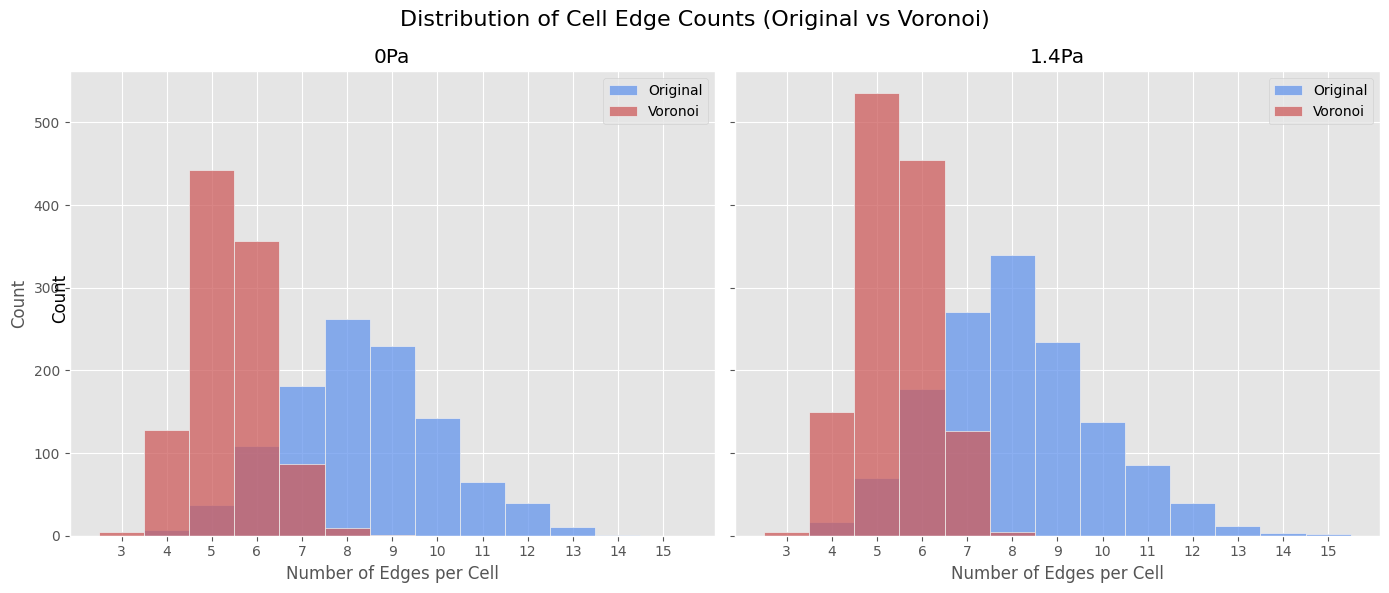

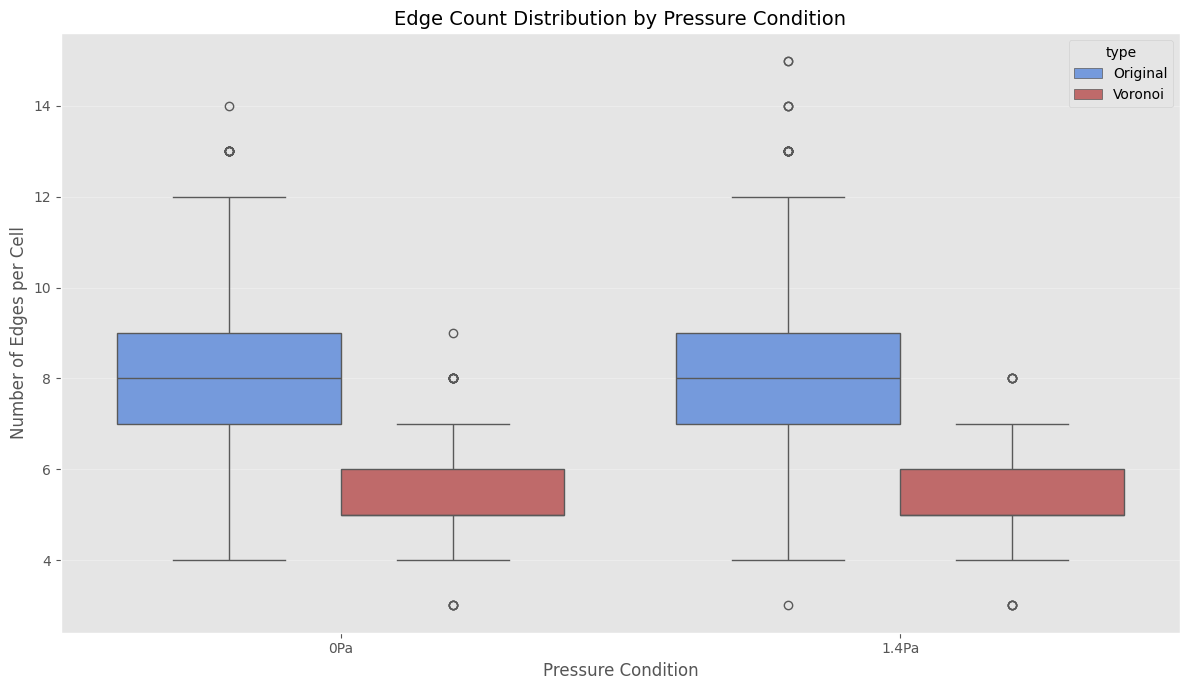

<Figure size 1600x800 with 0 Axes>

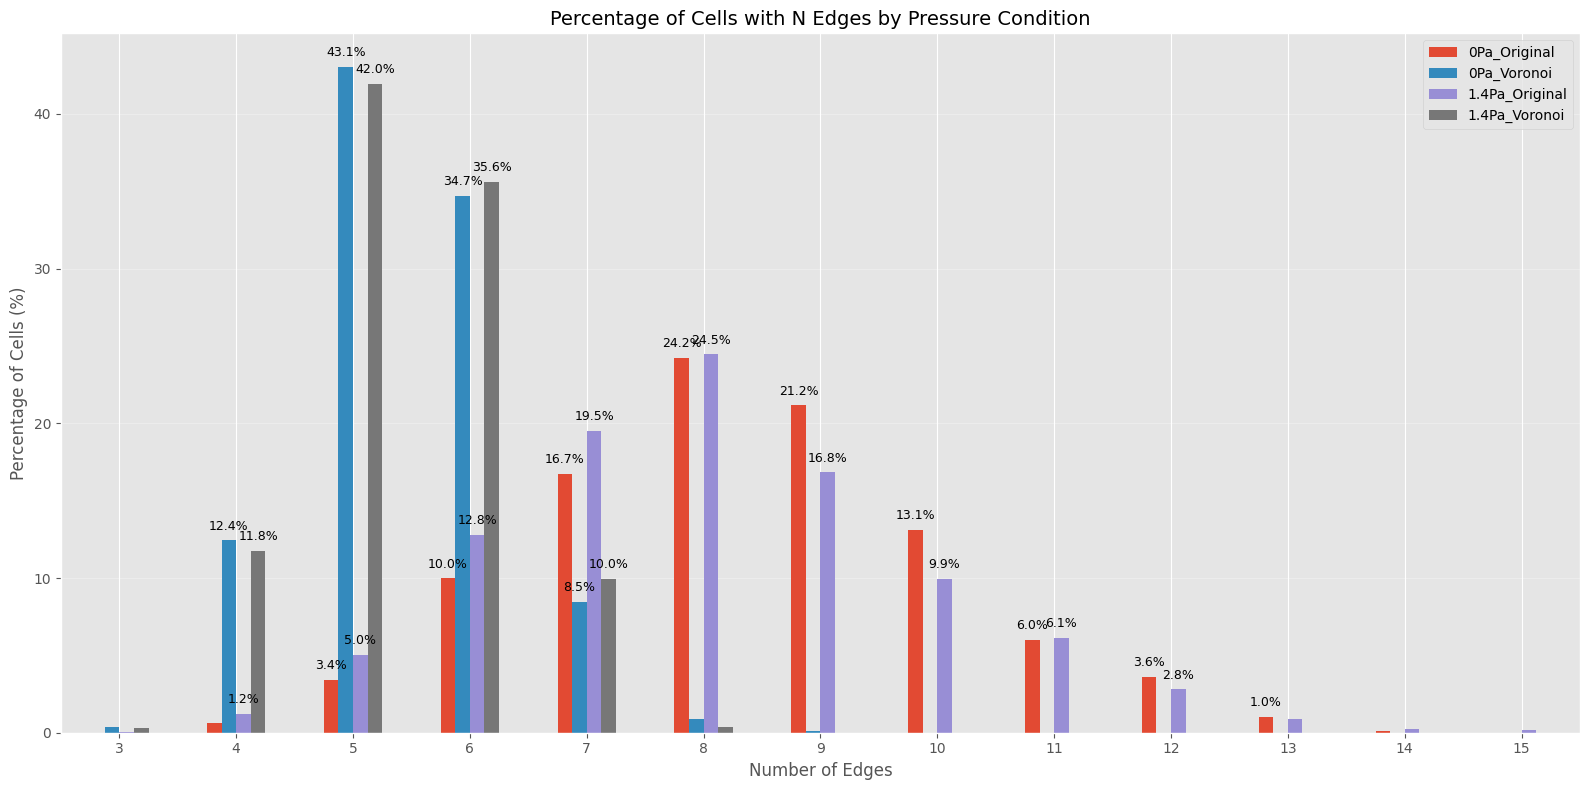

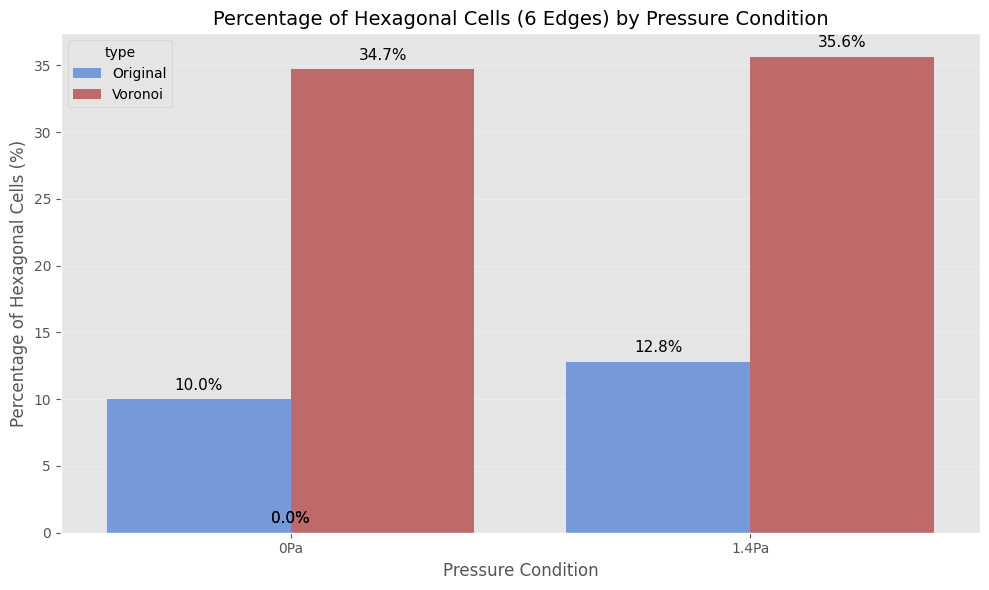


Summary of Edge Count Analysis:

Cell Edge Count Statistics:

0Pa - Original:
  Total cells: 1082
  Mean edges per cell: 8.36 ± 1.73
  Most common: 8 edges (24.2% of cells)
  Hexagonal cells: 10.0% (6 edges)

0Pa - Voronoi:
  Total cells: 1029
  Mean edges per cell: 5.41 ± 0.86
  Most common: 5 edges (43.1% of cells)
  Hexagonal cells: 34.7% (6 edges)

1.4Pa - Original:
  Total cells: 1390
  Mean edges per cell: 8.07 ± 1.82
  Most common: 8 edges (24.5% of cells)
  Hexagonal cells: 12.8% (6 edges)

1.4Pa - Voronoi:
  Total cells: 1275
  Mean edges per cell: 5.44 ± 0.85
  Most common: 5 edges (42.0% of cells)
  Hexagonal cells: 35.6% (6 edges)

0Pa - Change in hexagonal cells after Voronoi: +24.7%

1.4Pa - Change in hexagonal cells after Voronoi: +22.8%

Original masks - Difference in mean edges (1.4Pa vs 0Pa): -0.29

Voronoi masks - Difference in mean edges (1.4Pa vs 0Pa): +0.03

Cell Edge Distribution Analysis completed.
Results saved to: /content/drive/MyDrive/knowledge/University/M

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from scipy.spatial import Voronoi
from skimage import measure, io
import tifffile
import re
import seaborn as sns
from collections import defaultdict
from matplotlib.colors import LinearSegmentedColormap

# Path configuration
input_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/flow3-x20/Cell_merged_conservative"
output_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Analysis/flow3-x20/Overall/Cell/EdgeAnalysis"

# Create output directory
os.makedirs(output_dir, exist_ok=True)

# Function to find all mask files and group by pressure
def find_mask_files(base_dir):
    """
    Find all cell mask files and categorize by pressure condition.

    Returns:
        dict: Dictionary with pressure conditions as keys and lists of file paths as values
    """
    pressure_groups = defaultdict(list)

    # Pattern to extract pressure from filename
    pattern = r"^([\d\.]+Pa)_.*_cell_mask_merged_conservative\.tif$"

    for filename in os.listdir(base_dir):
        if filename.endswith("_cell_mask_merged_conservative.tif"):
            match = re.match(pattern, filename)
            if match:
                pressure = match.group(1)
                file_path = os.path.join(base_dir, filename)
                pressure_groups[pressure].append(file_path)

    return pressure_groups

# Voronoi regularization function
def voronoi_regularize_cells(cell_mask, min_area=100, boundary_buffer=5):
    """
    Regularize cell shapes using Voronoi diagrams.
    """
    # Ensure cell_mask is integer type
    if not np.issubdtype(cell_mask.dtype, np.integer):
        cell_mask = cell_mask.astype(np.int32)

    # Get image dimensions
    h, w = cell_mask.shape

    # Extract cell properties
    cell_props = measure.regionprops(cell_mask)

    # Collect centroids for Voronoi computation
    centroids = []
    cell_ids = []

    for prop in cell_props:
        # Skip small objects
        if prop.area < min_area:
            continue

        cell_ids.append(prop.label)
        y, x = prop.centroid
        centroids.append([x, y])

    if len(centroids) == 0:
        print("No valid cells found! Check your mask or reduce min_area.")
        return cell_mask, {}

    # Add boundary points to constrain Voronoi diagram
    boundary_points = []
    boundary_ids = []

    # Add boundary points around the image
    for x in range(0, w, boundary_buffer):
        boundary_points.append([x, -boundary_buffer])
        boundary_points.append([x, h+boundary_buffer])
        boundary_ids.extend([-1, -1])

    for y in range(0, h, boundary_buffer):
        boundary_points.append([-boundary_buffer, y])
        boundary_points.append([w+boundary_buffer, y])
        boundary_ids.extend([-1, -1])

    # Combine cell centroids with boundary points
    all_points = np.array(centroids + boundary_points)
    all_ids = cell_ids + boundary_ids

    # Compute Voronoi diagram
    try:
        vor = Voronoi(all_points)
    except Exception as e:
        print(f"Voronoi computation failed: {e}")
        print(f"Number of points: {len(all_points)}")
        return cell_mask, {}

    # Create a new mask for Voronoi-regularized cells
    voronoi_mask = np.zeros((h, w), dtype=np.int32)

    # Create mapping between original cell IDs and Voronoi cell IDs
    cell_mapping = {}

    # Draw each Voronoi region for each cell
    for i in range(len(cell_ids)):  # Only iterate through valid cell points (not boundary)
        # Get the region index for this point
        point_region_idx = vor.point_region[i]

        original_cell_id = all_ids[i]

        # Skip boundary cells
        if original_cell_id < 0:
            continue

        # Get the region vertices
        region = vor.regions[point_region_idx]

        # Skip open regions or degenerate cases
        if -1 in region or len(region) < 3:
            continue

        # Get the vertex coordinates
        vertices = np.array([vor.vertices[v] for v in region])

        # Clip to image boundaries
        vertices[:, 0] = np.clip(vertices[:, 0], 0, w-1)
        vertices[:, 1] = np.clip(vertices[:, 1], 0, h-1)

        # Convert to integer coordinates for drawing
        vertices_int = vertices.astype(np.int32)

        # Create mask for this Voronoi cell
        cell_region = np.zeros((h, w), dtype=np.uint8)
        cv2.fillPoly(cell_region, [vertices_int], 1)

        # Find the intersection with the original cell
        original_cell = (cell_mask == original_cell_id).astype(np.uint8)
        intersection = cv2.bitwise_and(cell_region, original_cell)

        # Only keep the Voronoi cell if it significantly overlaps with the original cell
        if np.sum(intersection) > 0.5 * np.sum(original_cell):
            # New cell ID (i+1 to avoid 0, which is background)
            new_cell_id = i + 1

            # Add this cell to the Voronoi mask
            voronoi_mask[cell_region > 0] = new_cell_id

            # Record the mapping
            cell_mapping[original_cell_id] = new_cell_id

    return voronoi_mask, cell_mapping

# Function to extract edge counts (vertices) from a mask
def extract_edge_counts(label_mask, min_area=100):
    """
    Extract the number of edges (vertices) for each cell in a mask.

    Returns:
        list: List of edge counts for each cell
    """
    # Ensure mask is integer type
    if not np.issubdtype(label_mask.dtype, np.integer):
        label_mask = label_mask.astype(np.int32)

    edge_counts = []

    # Get region properties
    props = measure.regionprops(label_mask)

    for prop in props:
        # Skip small objects
        if prop.area < min_area:
            continue

        # Get cell binary mask
        cell_mask = (label_mask == prop.label).astype(np.uint8)

        # Find contour for edge counting
        contours, _ = cv2.findContours(cell_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            continue

        contour = max(contours, key=cv2.contourArea)

        # Approximate contour to count vertices
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        vertices = len(approx)

        edge_counts.append(vertices)

    return edge_counts

# Function to process a mask file and extract edge counts
def process_file_for_edges(file_path):
    """
    Process a single cell mask file:
    1. Load the mask
    2. Apply Voronoi regularization
    3. Extract edge counts from both original and Voronoi masks

    Returns tuple of (original_edges, voronoi_edges)
    """
    print(f"Processing: {os.path.basename(file_path)}")

    # Load the mask
    mask = tifffile.imread(file_path)

    # Ensure mask is labeled (each cell has a unique ID)
    if np.max(mask) <= 1:
        # For binary masks, run connected component analysis to label each cell
        mask = mask.astype(np.uint8)
        _, labeled_mask = cv2.connectedComponents(mask)
    else:
        labeled_mask = mask

    # Apply Voronoi regularization
    voronoi_mask, _ = voronoi_regularize_cells(labeled_mask, min_area=100, boundary_buffer=10)

    # Extract edge counts from both masks
    original_edges = extract_edge_counts(labeled_mask)
    voronoi_edges = extract_edge_counts(voronoi_mask)

    print(f"  Original mask: {len(original_edges)} cells")
    print(f"  Voronoi mask: {len(voronoi_edges)} cells")

    return original_edges, voronoi_edges

# Function to visualize edge counts
def visualize_edge_counts(edge_data, output_dir):
    """
    Create visualizations of edge count distributions.

    Parameters:
    -----------
    edge_data : dict
        Dictionary with pressure conditions as keys, each containing a dict
        with 'original' and 'voronoi' lists of edge counts
    output_dir : str
        Directory to save visualizations
    """
    # First, create DataFrames for analysis
    all_data = []

    for pressure, data in edge_data.items():
        # Original data
        for edges in data['original']:
            all_data.append({
                'pressure': pressure,
                'edges': edges,
                'type': 'Original'
            })

        # Voronoi data
        for edges in data['voronoi']:
            all_data.append({
                'pressure': pressure,
                'edges': edges,
                'type': 'Voronoi'
            })

    # Create DataFrame
    df = pd.DataFrame(all_data)

    # Calculate statistics
    stats = []

    for pressure in edge_data.keys():
        # Original statistics
        orig_edges = edge_data[pressure]['original']
        orig_stats = {
            'pressure': pressure,
            'type': 'Original',
            'count': len(orig_edges),
            'mean_edges': np.mean(orig_edges),
            'median_edges': np.median(orig_edges),
            'std_edges': np.std(orig_edges),
            'min_edges': np.min(orig_edges),
            'max_edges': np.max(orig_edges)
        }
        stats.append(orig_stats)

        # Calculate most common edge count
        orig_counts = pd.Series(orig_edges).value_counts()
        most_common_orig = orig_counts.idxmax()
        orig_stats['most_common'] = most_common_orig
        orig_stats['most_common_pct'] = orig_counts[most_common_orig] / len(orig_edges) * 100

        # Calculate percentage of hexagonal cells (6 edges)
        orig_stats['hexagonal_pct'] = orig_counts.get(6, 0) / len(orig_edges) * 100 if len(orig_edges) > 0 else 0

        # Voronoi statistics
        vor_edges = edge_data[pressure]['voronoi']
        vor_stats = {
            'pressure': pressure,
            'type': 'Voronoi',
            'count': len(vor_edges),
            'mean_edges': np.mean(vor_edges),
            'median_edges': np.median(vor_edges),
            'std_edges': np.std(vor_edges),
            'min_edges': np.min(vor_edges),
            'max_edges': np.max(vor_edges)
        }
        stats.append(vor_stats)

        # Calculate most common edge count
        vor_counts = pd.Series(vor_edges).value_counts()
        most_common_vor = vor_counts.idxmax()
        vor_stats['most_common'] = most_common_vor
        vor_stats['most_common_pct'] = vor_counts[most_common_vor] / len(vor_edges) * 100

        # Calculate percentage of hexagonal cells (6 edges)
        vor_stats['hexagonal_pct'] = vor_counts.get(6, 0) / len(vor_edges) * 100 if len(vor_edges) > 0 else 0

    # Create DataFrame of statistics
    stats_df = pd.DataFrame(stats)

    # Save statistics
    stats_df.to_csv(os.path.join(output_dir, 'edge_count_statistics.csv'), index=False)

    # Create visualizations

    # 1. Histogram of edge counts by pressure and type
    plt.figure(figsize=(14, 10))

    # Get max edge count for consistent binning
    max_edges = max(df['edges'].max(), 15)  # Cap at 15 for readability
    bins = np.arange(2.5, max_edges + 1.5, 1)  # Bins centered on integers 3 to max

    # Create subplot for each pressure condition
    fig, axes = plt.subplots(1, len(edge_data.keys()), figsize=(14, 6), sharey=True)

    # If only one pressure condition, convert axes to list
    if len(edge_data.keys()) == 1:
        axes = [axes]

    # Plot histogram for each pressure condition
    for i, pressure in enumerate(sorted(edge_data.keys())):
        pressure_df = df[df['pressure'] == pressure]

        # Plot original
        sns.histplot(data=pressure_df[pressure_df['type'] == 'Original'],
                     x='edges', bins=bins, ax=axes[i],
                     label='Original', color='cornflowerblue')

        # Plot Voronoi
        sns.histplot(data=pressure_df[pressure_df['type'] == 'Voronoi'],
                     x='edges', bins=bins, ax=axes[i],
                     label='Voronoi', color='indianred')

        axes[i].set_title(f'{pressure}')
        axes[i].set_xlabel('Number of Edges per Cell')
        axes[i].legend()

        # Force x ticks to be integer values
        axes[i].set_xticks(range(3, int(max_edges) + 1))

    # Set common y label
    fig.text(0.04, 0.5, 'Count', va='center', rotation='vertical', fontsize=12)

    plt.suptitle('Distribution of Cell Edge Counts (Original vs Voronoi)', fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'edge_count_histogram_by_pressure.png'), dpi=300)
    plt.show()

    # 2. Box plot comparison
    plt.figure(figsize=(12, 7))
    sns.boxplot(x='pressure', y='edges', hue='type', data=df,
                palette=['cornflowerblue', 'indianred'])

    plt.title('Edge Count Distribution by Pressure Condition', fontsize=14)
    plt.xlabel('Pressure Condition', fontsize=12)
    plt.ylabel('Number of Edges per Cell', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'edge_count_boxplot.png'), dpi=300)
    plt.show()

    # 3. Stacked bar chart showing percentage of cells with N edges

    # Calculate percentages of N-edged cells
    pct_data = {}

    for pressure in edge_data.keys():
        # Original mask percentages
        orig_counts = pd.Series(edge_data[pressure]['original']).value_counts(normalize=True) * 100
        pct_data[f"{pressure}_Original"] = orig_counts

        # Voronoi mask percentages
        vor_counts = pd.Series(edge_data[pressure]['voronoi']).value_counts(normalize=True) * 100
        pct_data[f"{pressure}_Voronoi"] = vor_counts

    # Create DataFrame
    pct_df = pd.DataFrame(pct_data).fillna(0)

    # Plot as grouped bar chart
    plt.figure(figsize=(16, 8))
    ax = pct_df.plot(kind='bar', figsize=(16, 8))

    plt.title('Percentage of Cells with N Edges by Pressure Condition', fontsize=14)
    plt.xlabel('Number of Edges', fontsize=12)
    plt.ylabel('Percentage of Cells (%)', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=0)

    # Add value labels on top of bars
    for i, container in enumerate(ax.containers):
        # Add labels only for significant percentages (>1%)
        for j, val in enumerate(container):
            height = val.get_height()
            if height > 1:  # Only label bars with >1% value
                ax.text(val.get_x() + val.get_width()/2, height + 0.5,
                        f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'edge_count_percentage.png'), dpi=300)
    plt.show()

    # 4. Hexagonal cell percentage comparison

    # Extract hexagonal percentages
    hexagonal_data = stats_df[['pressure', 'type', 'hexagonal_pct']]

    plt.figure(figsize=(10, 6))

    # Create grouped bar chart for hexagonal percentage
    sns.barplot(x='pressure', y='hexagonal_pct', hue='type', data=hexagonal_data,
               palette=['cornflowerblue', 'indianred'])

    plt.title('Percentage of Hexagonal Cells (6 Edges) by Pressure Condition', fontsize=14)
    plt.xlabel('Pressure Condition', fontsize=12)
    plt.ylabel('Percentage of Hexagonal Cells (%)', fontsize=12)
    plt.grid(axis='y', alpha=0.3)

    # Add value labels on top of bars
    for i, p in enumerate(plt.gca().patches):
        height = p.get_height()
        plt.text(p.get_x() + p.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=11)

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'hexagonal_cell_percentage.png'), dpi=300)
    plt.show()

    # Save data
    pct_df.to_csv(os.path.join(output_dir, 'edge_count_percentages.csv'))
    df.to_csv(os.path.join(output_dir, 'all_edge_counts.csv'), index=False)

    # Print summary statistics
    print("\nSummary of Edge Count Analysis:")
    print("\nCell Edge Count Statistics:")
    for _, row in stats_df.iterrows():
        print(f"\n{row['pressure']} - {row['type']}:")
        print(f"  Total cells: {row['count']}")
        print(f"  Mean edges per cell: {row['mean_edges']:.2f} ± {row['std_edges']:.2f}")
        print(f"  Most common: {row['most_common']} edges ({row['most_common_pct']:.1f}% of cells)")
        print(f"  Hexagonal cells: {row['hexagonal_pct']:.1f}% (6 edges)")

    # Calculate the change in hexagonal percentage due to Voronoi
    for pressure in edge_data.keys():
        orig_hex = stats_df[(stats_df['pressure'] == pressure) & (stats_df['type'] == 'Original')]['hexagonal_pct'].values[0]
        vor_hex = stats_df[(stats_df['pressure'] == pressure) & (stats_df['type'] == 'Voronoi')]['hexagonal_pct'].values[0]
        change = vor_hex - orig_hex

        print(f"\n{pressure} - Change in hexagonal cells after Voronoi: {change:+.1f}%")

    # Compare the effect of pressure on edge distribution
    for type_val in ['Original', 'Voronoi']:
        pa0_mean = stats_df[(stats_df['pressure'] == '0Pa') & (stats_df['type'] == type_val)]['mean_edges'].values[0]
        pa14_mean = stats_df[(stats_df['pressure'] == '1.4Pa') & (stats_df['type'] == type_val)]['mean_edges'].values[0]
        diff = pa14_mean - pa0_mean

        print(f"\n{type_val} masks - Difference in mean edges (1.4Pa vs 0Pa): {diff:+.2f}")

    return {
        'stats_df': stats_df,
        'pct_df': pct_df,
        'all_counts_df': df
    }

# Main execution function
def main():
    print("Starting Cell Edge Distribution Analysis...")

    # Find all mask files grouped by pressure
    pressure_groups = find_mask_files(input_dir)

    # Print files found
    print("\nFiles found by pressure condition:")
    for pressure, files in pressure_groups.items():
        print(f"\n{pressure}: {len(files)} files")
        for file in files:
            print(f"  - {os.path.basename(file)}")

    # Process files and extract edge counts
    edge_data = {}

    for pressure, files in pressure_groups.items():
        print(f"\n\nProcessing {pressure} condition files...")

        # Initialize lists for this pressure
        edge_data[pressure] = {
            'original': [],
            'voronoi': []
        }

        # Process each file
        for file in files:
            orig_edges, vor_edges = process_file_for_edges(file)

            # Add to the lists
            edge_data[pressure]['original'].extend(orig_edges)
            edge_data[pressure]['voronoi'].extend(vor_edges)

        # Print summary for this pressure
        print(f"\nSummary for {pressure}:")
        print(f"  Total cells in original masks: {len(edge_data[pressure]['original'])}")
        print(f"  Total cells in Voronoi masks: {len(edge_data[pressure]['voronoi'])}")

    # Visualize the edge count data
    print("\nCreating visualizations...")
    results = visualize_edge_counts(edge_data, output_dir)

    print("\nCell Edge Distribution Analysis completed.")
    print(f"Results saved to: {output_dir}")

if __name__ == "__main__":
    main()

Starting Cell Size vs Edge Count Analysis...

Files found by pressure condition:

0Pa: 3 files
  - 0Pa_U_05mar19_20x_L2RA_Flat_seq001_cell_mask_merged_conservative.tif
  - 0Pa_U_05mar19_20x_L2RA_Flat_seq002_cell_mask_merged_conservative.tif
  - 0Pa_U_05mar19_20x_L2RA_Flat_seq003_cell_mask_merged_conservative.tif

1.4Pa: 5 files
  - 1.4Pa_U_05mar19_20x_L2R_Flat_seq001_cell_mask_merged_conservative.tif
  - 1.4Pa_U_05mar19_20x_L2R_Flat_seq002_cell_mask_merged_conservative.tif
  - 1.4Pa_U_05mar19_20x_L2R_Flat_seq003_cell_mask_merged_conservative.tif
  - 1.4Pa_U_05mar19_20x_L2R_Flat_seq004_cell_mask_merged_conservative.tif
  - 1.4Pa_U_05mar19_20x_L2R_Flat_seq005_cell_mask_merged_conservative.tif


Processing 0Pa condition files...
Processing: 0Pa_U_05mar19_20x_L2RA_Flat_seq001_cell_mask_merged_conservative.tif
  Original mask: 329 cells
  Voronoi mask: 309 cells
Processing: 0Pa_U_05mar19_20x_L2RA_Flat_seq002_cell_mask_merged_conservative.tif
  Original mask: 368 cells
  Voronoi mask: 350 ce

<ipython-input-19-15aac76c71a5>:353: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1600x1000 with 0 Axes>

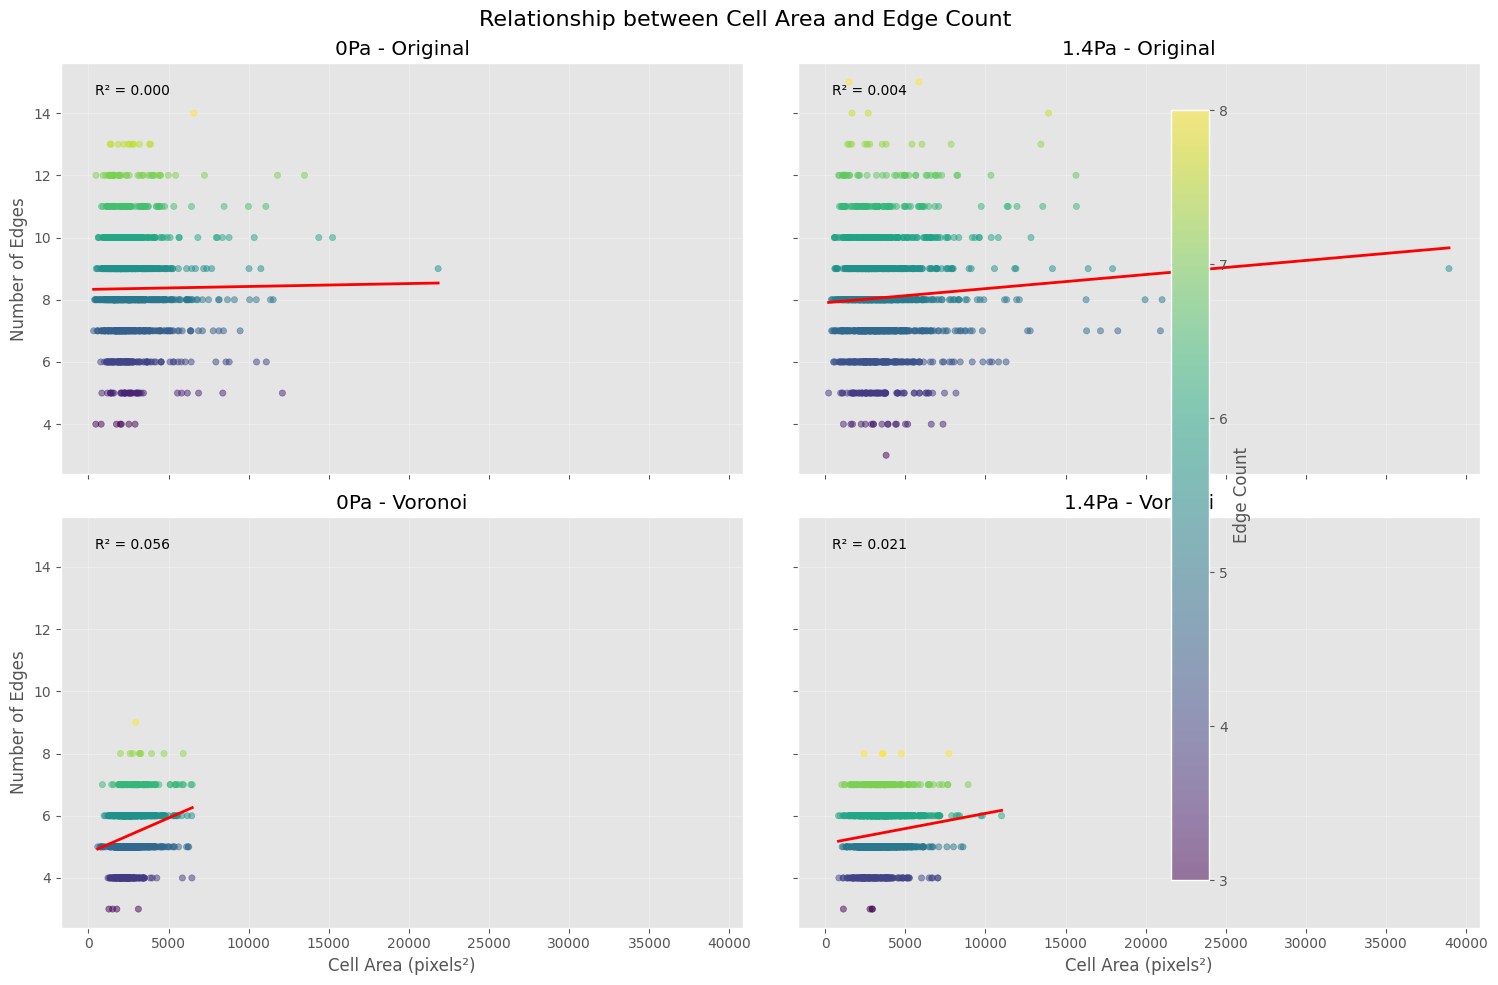

<ipython-input-19-15aac76c71a5>:378: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='edges', y='area', data=subset, ax=axes[i, j], palette='viridis')
<ipython-input-19-15aac76c71a5>:378: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='edges', y='area', data=subset, ax=axes[i, j], palette='viridis')
<ipython-input-19-15aac76c71a5>:378: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='edges', y='area', data=subset, ax=axes[i, j], palette='viridis')
<ipython-input-19-15aac76c71a5>:378: FutureWarning: 

Passing `palette` without assigning `hue

<Figure size 1600x1200 with 0 Axes>

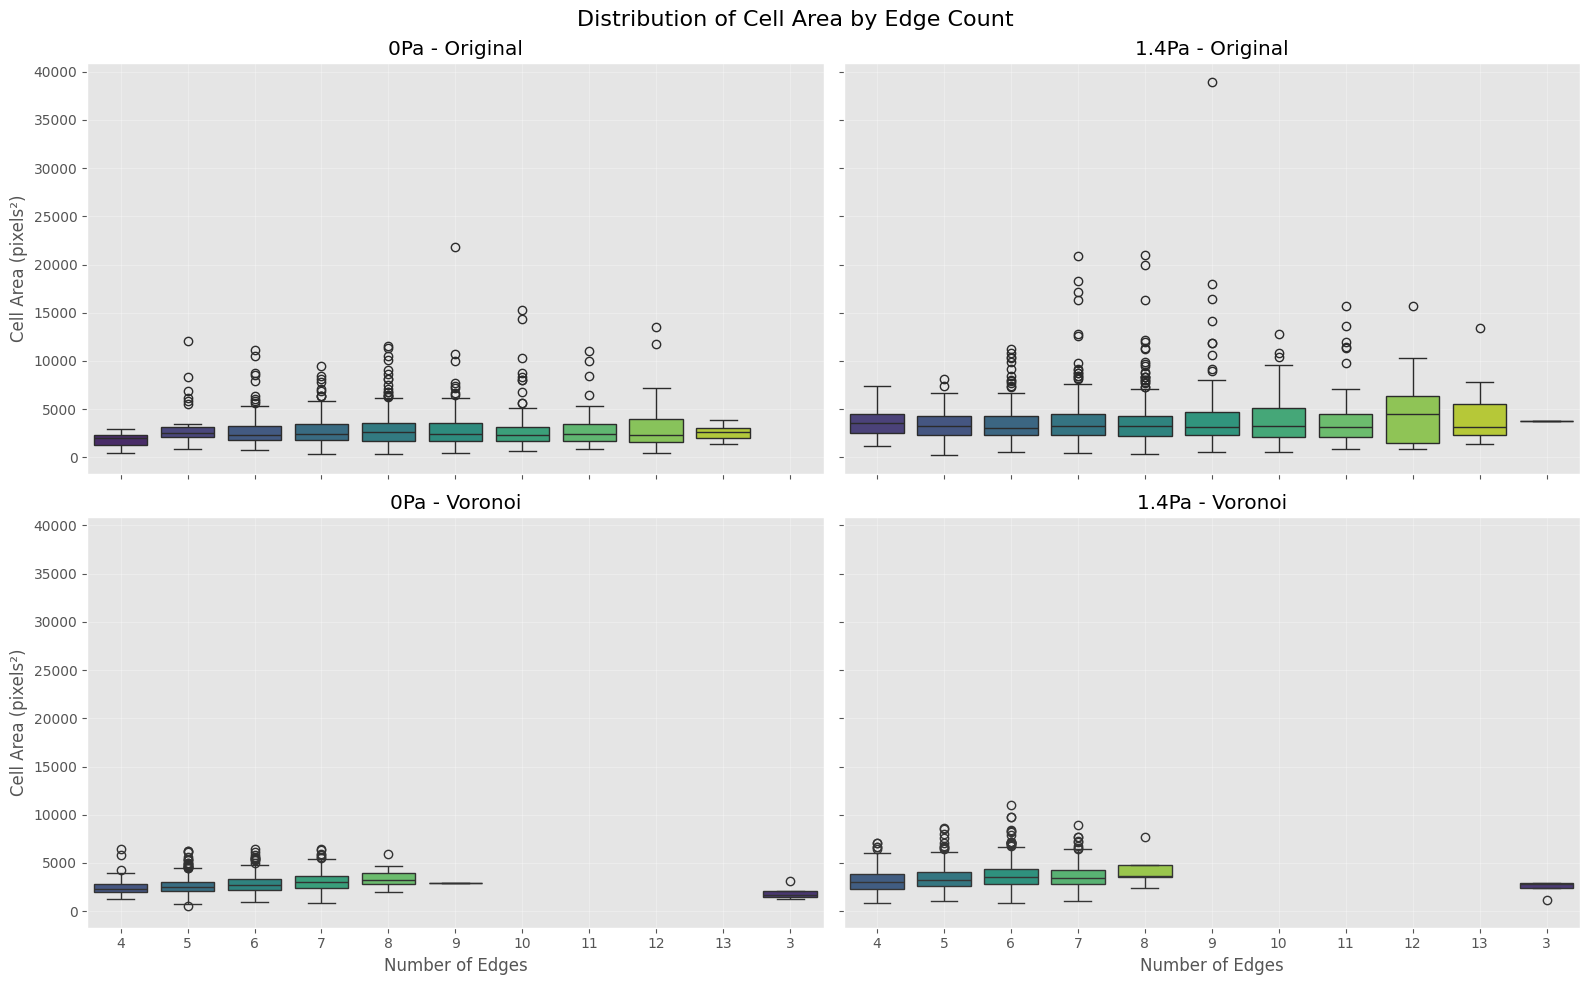

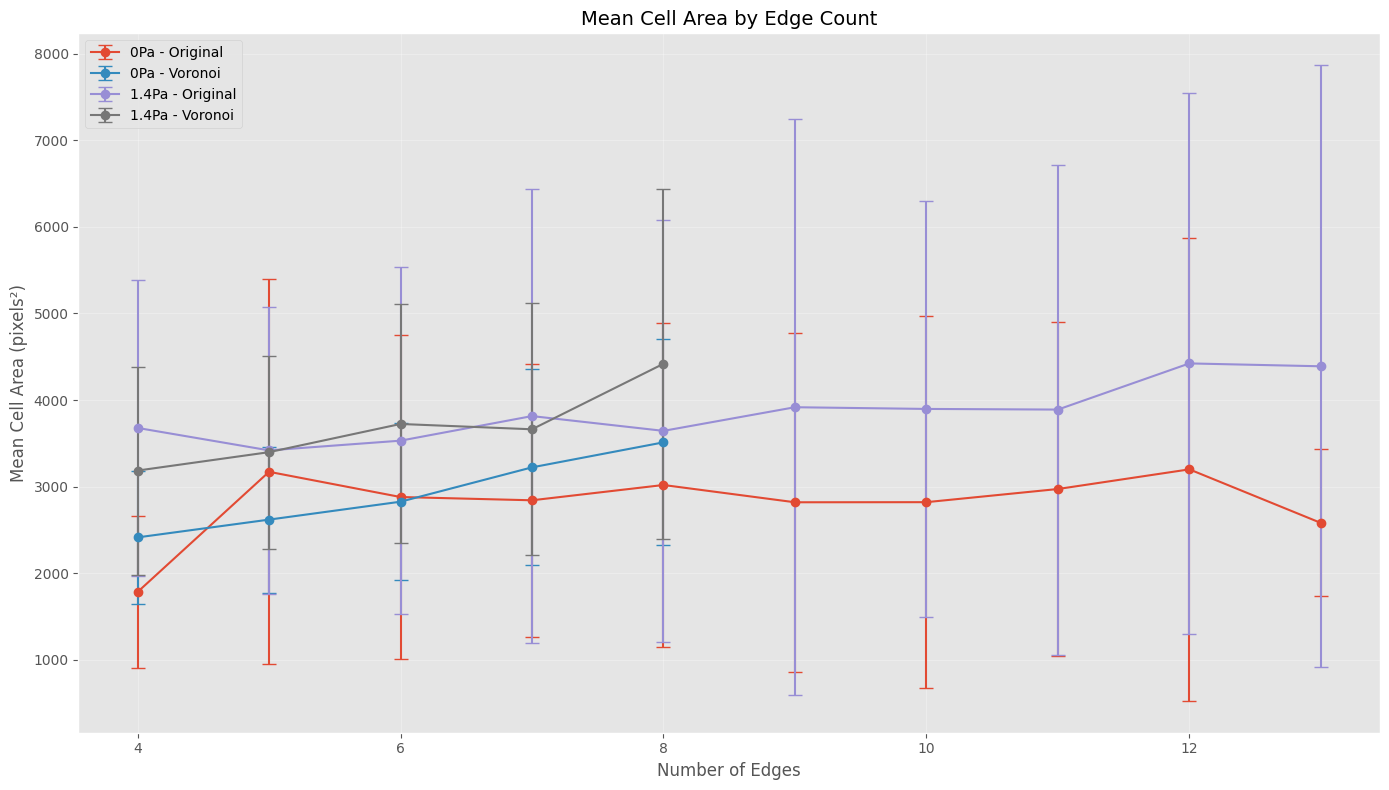

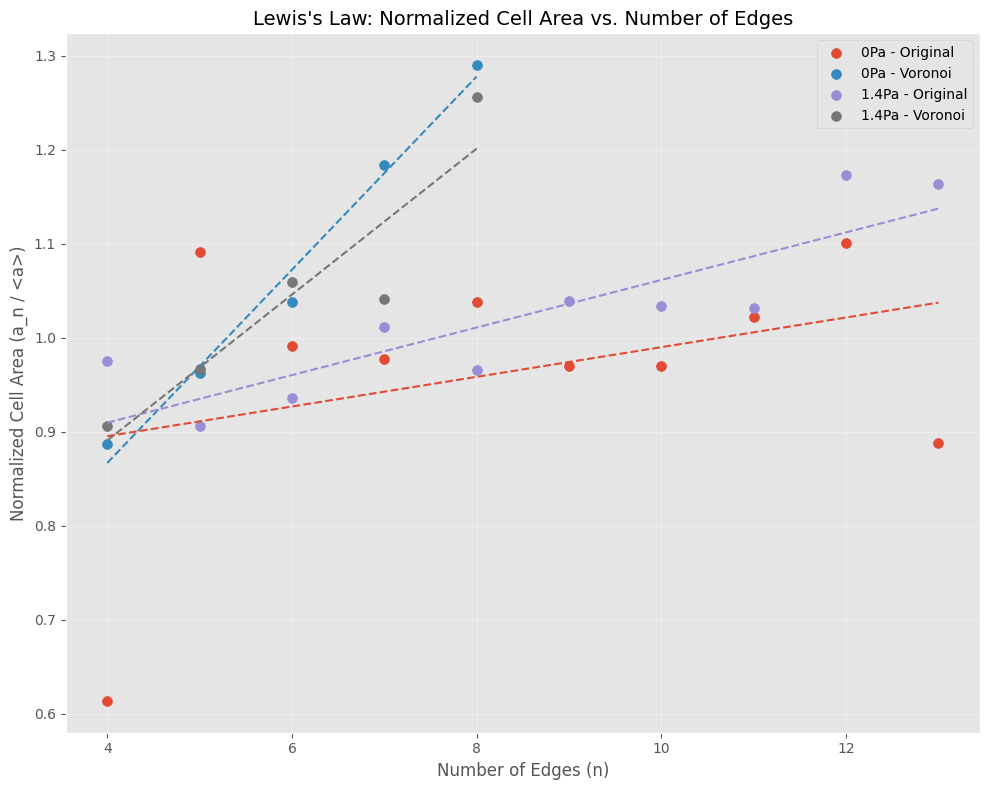

<ipython-input-19-15aac76c71a5>:469: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='edges', y='area', data=subset, palette='viridis')
<ipython-input-19-15aac76c71a5>:469: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='edges', y='area', data=subset, palette='viridis')
<ipython-input-19-15aac76c71a5>:469: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='edges', y='area', data=subset, palette='viridis')
<ipython-input-19-15aac76c71a5>:469: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed 

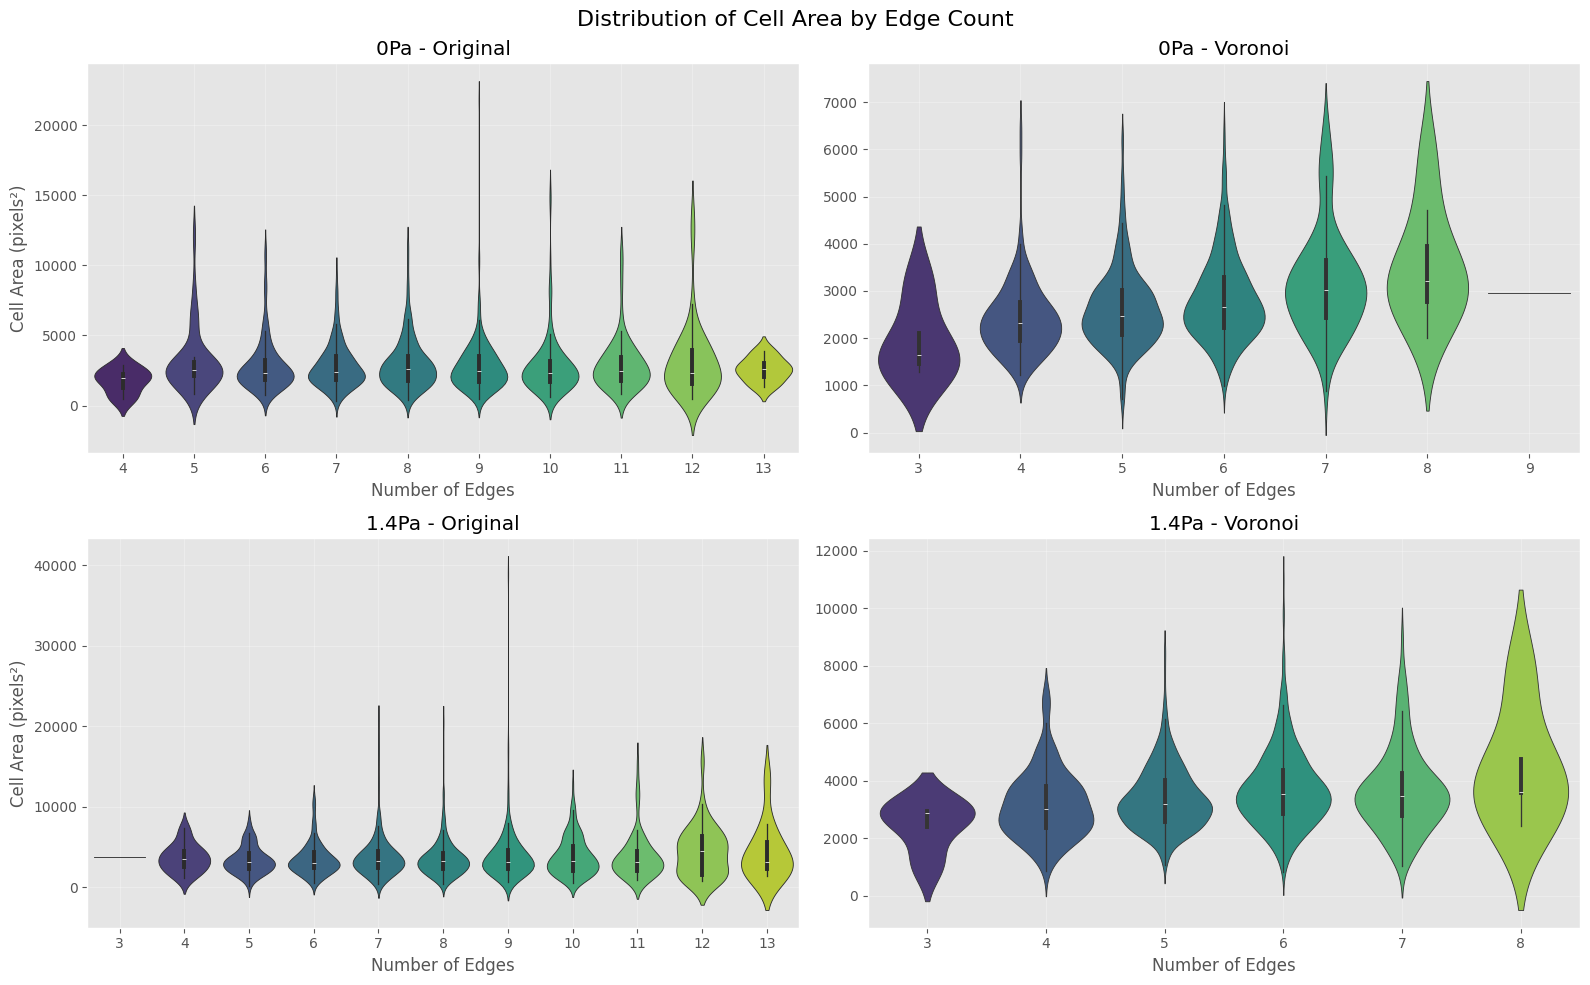

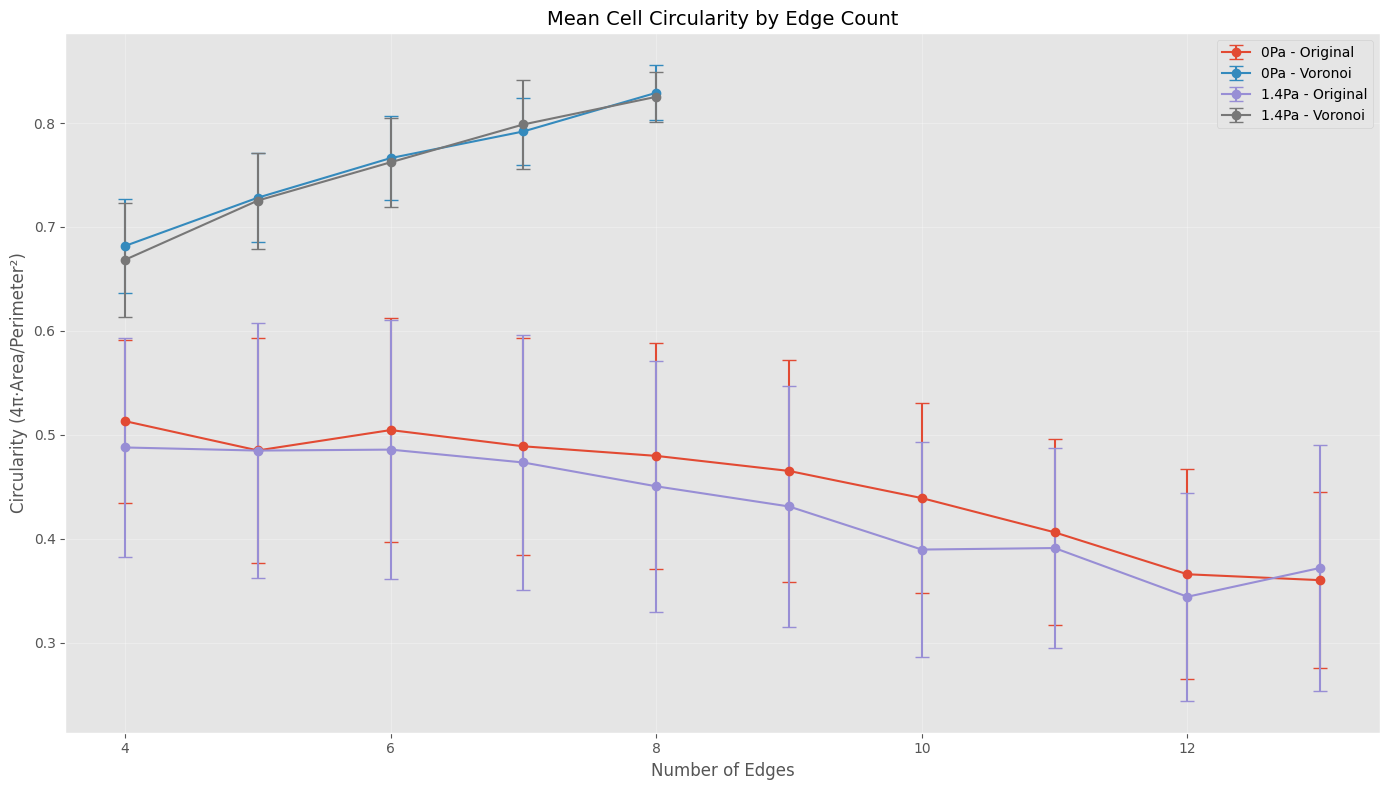


Analysis completed. Files saved to: /content/drive/MyDrive/knowledge/University/Master/Thesis/Analysis/flow3-x20/Overall/Cell/SizeEdgeAnalysis

Key findings:
  - Overall Pearson correlation: 0.1463
  - Lewis's Law fit R²: 0.0214

Cell Size vs Edge Count Analysis completed.
Results saved to: /content/drive/MyDrive/knowledge/University/Master/Thesis/Analysis/flow3-x20/Overall/Cell/SizeEdgeAnalysis


In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from scipy.spatial import Voronoi
from skimage import measure, io
import tifffile
import re
import seaborn as sns
from collections import defaultdict
from matplotlib.colors import LinearSegmentedColormap
from scipy import stats

# Path configuration
input_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/flow3-x20/Cell_merged_conservative"
output_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Analysis/flow3-x20/Overall/Cell/SizeEdgeAnalysis"

# Create output directory
os.makedirs(output_dir, exist_ok=True)

# Function to find all mask files and group by pressure
def find_mask_files(base_dir):
    """
    Find all cell mask files and categorize by pressure condition.

    Returns:
        dict: Dictionary with pressure conditions as keys and lists of file paths as values
    """
    pressure_groups = defaultdict(list)

    # Pattern to extract pressure from filename
    pattern = r"^([\d\.]+Pa)_.*_cell_mask_merged_conservative\.tif$"

    for filename in os.listdir(base_dir):
        if filename.endswith("_cell_mask_merged_conservative.tif"):
            match = re.match(pattern, filename)
            if match:
                pressure = match.group(1)
                file_path = os.path.join(base_dir, filename)
                pressure_groups[pressure].append(file_path)

    return pressure_groups

# Voronoi regularization function (same as original)
def voronoi_regularize_cells(cell_mask, min_area=100, boundary_buffer=5):
    """
    Regularize cell shapes using Voronoi diagrams.
    """
    # Ensure cell_mask is integer type
    if not np.issubdtype(cell_mask.dtype, np.integer):
        cell_mask = cell_mask.astype(np.int32)

    # Get image dimensions
    h, w = cell_mask.shape

    # Extract cell properties
    cell_props = measure.regionprops(cell_mask)

    # Collect centroids for Voronoi computation
    centroids = []
    cell_ids = []

    for prop in cell_props:
        # Skip small objects
        if prop.area < min_area:
            continue

        cell_ids.append(prop.label)
        y, x = prop.centroid
        centroids.append([x, y])

    if len(centroids) == 0:
        print("No valid cells found! Check your mask or reduce min_area.")
        return cell_mask, {}

    # Add boundary points to constrain Voronoi diagram
    boundary_points = []
    boundary_ids = []

    # Add boundary points around the image
    for x in range(0, w, boundary_buffer):
        boundary_points.append([x, -boundary_buffer])
        boundary_points.append([x, h+boundary_buffer])
        boundary_ids.extend([-1, -1])

    for y in range(0, h, boundary_buffer):
        boundary_points.append([-boundary_buffer, y])
        boundary_points.append([w+boundary_buffer, y])
        boundary_ids.extend([-1, -1])

    # Combine cell centroids with boundary points
    all_points = np.array(centroids + boundary_points)
    all_ids = cell_ids + boundary_ids

    # Compute Voronoi diagram
    try:
        vor = Voronoi(all_points)
    except Exception as e:
        print(f"Voronoi computation failed: {e}")
        print(f"Number of points: {len(all_points)}")
        return cell_mask, {}

    # Create a new mask for Voronoi-regularized cells
    voronoi_mask = np.zeros((h, w), dtype=np.int32)

    # Create mapping between original cell IDs and Voronoi cell IDs
    cell_mapping = {}

    # Draw each Voronoi region for each cell
    for i in range(len(cell_ids)):  # Only iterate through valid cell points (not boundary)
        # Get the region index for this point
        point_region_idx = vor.point_region[i]

        original_cell_id = all_ids[i]

        # Skip boundary cells
        if original_cell_id < 0:
            continue

        # Get the region vertices
        region = vor.regions[point_region_idx]

        # Skip open regions or degenerate cases
        if -1 in region or len(region) < 3:
            continue

        # Get the vertex coordinates
        vertices = np.array([vor.vertices[v] for v in region])

        # Clip to image boundaries
        vertices[:, 0] = np.clip(vertices[:, 0], 0, w-1)
        vertices[:, 1] = np.clip(vertices[:, 1], 0, h-1)

        # Convert to integer coordinates for drawing
        vertices_int = vertices.astype(np.int32)

        # Create mask for this Voronoi cell
        cell_region = np.zeros((h, w), dtype=np.uint8)
        cv2.fillPoly(cell_region, [vertices_int], 1)

        # Find the intersection with the original cell
        original_cell = (cell_mask == original_cell_id).astype(np.uint8)
        intersection = cv2.bitwise_and(cell_region, original_cell)

        # Only keep the Voronoi cell if it significantly overlaps with the original cell
        if np.sum(intersection) > 0.5 * np.sum(original_cell):
            # New cell ID (i+1 to avoid 0, which is background)
            new_cell_id = i + 1

            # Add this cell to the Voronoi mask
            voronoi_mask[cell_region > 0] = new_cell_id

            # Record the mapping
            cell_mapping[original_cell_id] = new_cell_id

    return voronoi_mask, cell_mapping

# NEW FUNCTION: Extract cell properties including area and edge count
def extract_cell_properties(label_mask, min_area=100):
    """
    Extract cell properties including area and number of edges for each cell.

    Returns:
        list: List of dictionaries with cell properties (area, edges)
    """
    # Ensure mask is integer type
    if not np.issubdtype(label_mask.dtype, np.integer):
        label_mask = label_mask.astype(np.int32)

    cell_properties = []

    # Get region properties
    props = measure.regionprops(label_mask)

    for prop in props:
        # Skip small objects
        if prop.area < min_area:
            continue

        # Get cell binary mask
        cell_mask = (label_mask == prop.label).astype(np.uint8)

        # Find contour for edge counting
        contours, _ = cv2.findContours(cell_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            continue

        contour = max(contours, key=cv2.contourArea)

        # Approximate contour to count vertices
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        vertices = len(approx)

        # Calculate cell perimeter
        perimeter = cv2.arcLength(contour, True)

        # Store properties
        cell_properties.append({
            'area': prop.area,
            'edges': vertices,
            'perimeter': perimeter,
            'circularity': 4 * np.pi * prop.area / (perimeter * perimeter) if perimeter > 0 else 0,
            'eccentricity': prop.eccentricity,
            'equivalent_diameter': prop.equivalent_diameter
        })

    return cell_properties

# Function to process a mask file and extract cell properties
def process_file_for_size_edge_analysis(file_path):
    """
    Process a single cell mask file:
    1. Load the mask
    2. Apply Voronoi regularization
    3. Extract cell properties from both original and Voronoi masks

    Returns tuple of (original_properties, voronoi_properties)
    """
    print(f"Processing: {os.path.basename(file_path)}")

    # Load the mask
    mask = tifffile.imread(file_path)

    # Ensure mask is labeled (each cell has a unique ID)
    if np.max(mask) <= 1:
        # For binary masks, run connected component analysis to label each cell
        mask = mask.astype(np.uint8)
        _, labeled_mask = cv2.connectedComponents(mask)
    else:
        labeled_mask = mask

    # Apply Voronoi regularization
    voronoi_mask, _ = voronoi_regularize_cells(labeled_mask, min_area=100, boundary_buffer=10)

    # Extract cell properties from both masks
    original_properties = extract_cell_properties(labeled_mask)
    voronoi_properties = extract_cell_properties(voronoi_mask)

    print(f"  Original mask: {len(original_properties)} cells")
    print(f"  Voronoi mask: {len(voronoi_properties)} cells")

    return original_properties, voronoi_properties

# Function to visualize cell size vs edge count relationship
def visualize_size_edge_relationship(cell_data, output_dir):
    """
    Create visualizations of the relationship between cell size and edge count.

    Parameters:
    -----------
    cell_data : dict
        Dictionary with pressure conditions as keys, each containing a dict
        with 'original' and 'voronoi' lists of cell properties
    output_dir : str
        Directory to save visualizations
    """
    # First, create DataFrames for analysis
    all_data = []

    for pressure, data in cell_data.items():
        # Original data
        for cell_prop in data['original']:
            cell_info = {
                'pressure': pressure,
                'edges': cell_prop['edges'],
                'area': cell_prop['area'],
                'perimeter': cell_prop['perimeter'],
                'circularity': cell_prop['circularity'],
                'eccentricity': cell_prop['eccentricity'],
                'equivalent_diameter': cell_prop['equivalent_diameter'],
                'type': 'Original'
            }
            all_data.append(cell_info)

        # Voronoi data
        for cell_prop in data['voronoi']:
            cell_info = {
                'pressure': pressure,
                'edges': cell_prop['edges'],
                'area': cell_prop['area'],
                'perimeter': cell_prop['perimeter'],
                'circularity': cell_prop['circularity'],
                'eccentricity': cell_prop['eccentricity'],
                'equivalent_diameter': cell_prop['equivalent_diameter'],
                'type': 'Voronoi'
            }
            all_data.append(cell_info)

    # Create DataFrame
    df = pd.DataFrame(all_data)

    # Save raw data
    df.to_csv(os.path.join(output_dir, 'cell_size_edge_data.csv'), index=False)

    # Calculate statistics by edge count
    edge_stats = df.groupby(['pressure', 'type', 'edges']).agg({
        'area': ['count', 'mean', 'std', 'min', 'median', 'max'],
        'perimeter': ['mean', 'std'],
        'circularity': ['mean', 'std']
    }).reset_index()

    # Create more readable column names
    edge_stats.columns = ['_'.join(col).strip('_') for col in edge_stats.columns.values]

    # Save edge group statistics
    edge_stats.to_csv(os.path.join(output_dir, 'edge_group_statistics.csv'), index=False)

    # 1. Scatter plot of cell area vs edge count
    plt.figure(figsize=(16, 10))

    # Create subplots for each pressure and type
    pressures = df['pressure'].unique()
    types = df['type'].unique()

    fig, axes = plt.subplots(len(types), len(pressures), figsize=(15, 10), sharex=True, sharey=True)

    # Adjust if only one pressure condition
    if len(pressures) == 1:
        axes = axes.reshape(-1, 1)

    for i, type_val in enumerate(types):
        for j, pressure in enumerate(pressures):
            subset = df[(df['pressure'] == pressure) & (df['type'] == type_val)]

            # Plot scatter
            scatter = axes[i, j].scatter(subset['area'], subset['edges'],
                                         alpha=0.5, s=20, c=subset['edges'], cmap='viridis')

            # Add linear regression line
            if len(subset) > 1:  # Ensure there's enough data for regression
                slope, intercept, r_value, p_value, std_err = stats.linregress(subset['area'], subset['edges'])
                x_vals = np.array([subset['area'].min(), subset['area'].max()])
                y_vals = intercept + slope * x_vals
                axes[i, j].plot(x_vals, y_vals, 'r-', linewidth=2)
                r_squared = r_value**2
                axes[i, j].text(0.05, 0.95, f'R² = {r_squared:.3f}', transform=axes[i, j].transAxes,
                                fontsize=10, verticalalignment='top')

            # Set title and labels
            axes[i, j].set_title(f'{pressure} - {type_val}')
            axes[i, j].grid(True, alpha=0.3)

            if j == 0:
                axes[i, j].set_ylabel('Number of Edges')
            if i == len(types) - 1:
                axes[i, j].set_xlabel('Cell Area (pixels²)')

    plt.colorbar(scatter, ax=axes, label='Edge Count')
    plt.suptitle('Relationship between Cell Area and Edge Count', fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'area_vs_edges_scatter.png'), dpi=300)
    plt.show()

    # 2. Box plot of cell area by edge count
    plt.figure(figsize=(16, 12))

    # Filter edge counts with sufficient samples
    edge_counts = df.groupby('edges').size()
    valid_edges = edge_counts[edge_counts >= 5].index.tolist()

    # Create subplots for each pressure and type
    fig, axes = plt.subplots(len(types), len(pressures), figsize=(16, 10), sharex=True, sharey=True)

    # Adjust if only one pressure condition
    if len(pressures) == 1:
        axes = axes.reshape(-1, 1)

    for i, type_val in enumerate(types):
        for j, pressure in enumerate(pressures):
            subset = df[(df['pressure'] == pressure) &
                         (df['type'] == type_val) &
                         (df['edges'].isin(valid_edges))]

            # Plot boxplot
            sns.boxplot(x='edges', y='area', data=subset, ax=axes[i, j], palette='viridis')

            # Set title and labels
            axes[i, j].set_title(f'{pressure} - {type_val}')
            axes[i, j].grid(True, alpha=0.3)

            if j == 0:
                axes[i, j].set_ylabel('Cell Area (pixels²)')
            if i == len(types) - 1:
                axes[i, j].set_xlabel('Number of Edges')

    plt.suptitle('Distribution of Cell Area by Edge Count', fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'area_boxplot_by_edges.png'), dpi=300)
    plt.show()

    # 3. Mean area vs edge count with error bars
    plt.figure(figsize=(14, 8))

    for pressure in pressures:
        for type_val in types:
            subset_stats = edge_stats[(edge_stats['pressure'] == pressure) &
                                      (edge_stats['type'] == type_val)]

            # Filter by min count for statistical significance
            subset_stats = subset_stats[subset_stats['area_count'] >= 5]

            plt.errorbar(subset_stats['edges'], subset_stats['area_mean'],
                         yerr=subset_stats['area_std'],
                         fmt='o-', capsize=5,
                         label=f'{pressure} - {type_val}')

    plt.title('Mean Cell Area by Edge Count', fontsize=14)
    plt.xlabel('Number of Edges', fontsize=12)
    plt.ylabel('Mean Cell Area (pixels²)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'mean_area_by_edges.png'), dpi=300)
    plt.show()

    # 4. Correlation analysis - Lewis's Law and Aboav-Weaire Law
    # Lewis's Law: The area of a cell is proportional to its number of sides
    # Aboav-Weaire Law: Cells with more sides tend to have neighbors with fewer sides

    plt.figure(figsize=(10, 8))

    for pressure in pressures:
        for type_val in types:
            subset_stats = edge_stats[(edge_stats['pressure'] == pressure) &
                                      (edge_stats['type'] == type_val)]

            # Filter by min count
            subset_stats = subset_stats[subset_stats['area_count'] >= 5]

            # Calculate normalized area (area / mean area)
            mean_area = df[(df['pressure'] == pressure) & (df['type'] == type_val)]['area'].mean()
            subset_stats['norm_area'] = subset_stats['area_mean'] / mean_area

            # Lewis's Law plot: n vs. normalized area
            plt.scatter(subset_stats['edges'], subset_stats['norm_area'],
                        label=f'{pressure} - {type_val}', s=50)

            # Linear fit for Lewis's Law (a_n ≈ a₀(n-n₀))
            if len(subset_stats) > 2:
                slope, intercept, r_value, p_value, std_err = stats.linregress(
                    subset_stats['edges'], subset_stats['norm_area'])
                x_vals = np.array([subset_stats['edges'].min(), subset_stats['edges'].max()])
                y_vals = intercept + slope * x_vals
                plt.plot(x_vals, y_vals, '--', linewidth=1.5)

    plt.title("Lewis's Law: Normalized Cell Area vs. Number of Edges", fontsize=14)
    plt.xlabel('Number of Edges (n)', fontsize=12)
    plt.ylabel('Normalized Cell Area (a_n / <a>)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'lewis_law_analysis.png'), dpi=300)
    plt.show()

    # 5. Cell size distribution by edge count
    plt.figure(figsize=(16, 10))

    # Create violin plots of area distribution by edge count
    for i, (pressure, type_val) in enumerate([(p, t) for p in pressures for t in types]):
        plt.subplot(len(types), len(pressures), i+1)

        subset = df[(df['pressure'] == pressure) &
                    (df['type'] == type_val) &
                    (df['edges'].isin(valid_edges))]

        sns.violinplot(x='edges', y='area', data=subset, palette='viridis')

        plt.title(f'{pressure} - {type_val}')
        plt.xlabel('Number of Edges')
        plt.ylabel('Cell Area (pixels²)' if i % len(pressures) == 0 else '')
        plt.grid(True, alpha=0.3)

    plt.suptitle('Distribution of Cell Area by Edge Count', fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'area_violin_by_edges.png'), dpi=300)
    plt.show()

    # 6. Cell circularity vs edge count
    plt.figure(figsize=(14, 8))

    for pressure in pressures:
        for type_val in types:
            subset_stats = edge_stats[(edge_stats['pressure'] == pressure) &
                                      (edge_stats['type'] == type_val)]

            # Filter by min count
            subset_stats = subset_stats[subset_stats['area_count'] >= 5]

            plt.errorbar(subset_stats['edges'], subset_stats['circularity_mean'],
                         yerr=subset_stats['circularity_std'],
                         fmt='o-', capsize=5,
                         label=f'{pressure} - {type_val}')

    plt.title('Mean Cell Circularity by Edge Count', fontsize=14)
    plt.xlabel('Number of Edges', fontsize=12)
    plt.ylabel('Circularity (4π·Area/Perimeter²)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'circularity_by_edges.png'), dpi=300)
    plt.show()

    # Calculate statistics and correlations
    stats_report = "Cell Size vs Edge Count Analysis Report\n"
    stats_report += "=" * 50 + "\n\n"

    for pressure in pressures:
        for type_val in types:
            subset = df[(df['pressure'] == pressure) & (df['type'] == type_val)]

            stats_report += f"\n{pressure} - {type_val}:\n"
            stats_report += "-" * 30 + "\n"

            # Calculate correlation coefficients
            pearson_corr = subset[['area', 'edges']].corr(method='pearson').iloc[0, 1]
            spearman_corr = subset[['area', 'edges']].corr(method='spearman').iloc[0, 1]

            stats_report += f"Number of cells: {len(subset)}\n"
            stats_report += f"Pearson correlation (area vs edges): {pearson_corr:.4f}\n"
            stats_report += f"Spearman correlation (area vs edges): {spearman_corr:.4f}\n"

            # Calculate average area by edge count
            edge_areas = subset.groupby('edges')['area'].agg(['mean', 'std', 'count'])
            stats_report += "\nAverage cell area by edge count:\n"

            for edge, row in edge_areas.iterrows():
                if row['count'] >= 5:  # Only include statistically significant counts
                    stats_report += f"  {edge} edges: {row['mean']:.2f} ± {row['std']:.2f} pixels² (n={int(row['count'])})\n"

            # Calculate Lewis's Law fit (area ~ n)
            if len(subset) > 2:
                slope, intercept, r_value, p_value, std_err = stats.linregress(
                    subset['edges'], subset['area'])
                r_squared = r_value**2

                stats_report += f"\nLewis's Law Analysis:\n"
                stats_report += f"  Linear fit: Area = {slope:.2f}·n + {intercept:.2f}\n"
                stats_report += f"  R²: {r_squared:.4f}, p-value: {p_value:.4e}\n"

    # Save statistics report
    with open(os.path.join(output_dir, 'size_edge_statistics_report.txt'), 'w') as f:
        f.write(stats_report)

    print("\nAnalysis completed. Files saved to:", output_dir)
    print("\nKey findings:")
    print(f"  - Overall Pearson correlation: {pearson_corr:.4f}")
    print(f"  - Lewis's Law fit R²: {r_squared:.4f}")

    return {
        'df': df,
        'edge_stats': edge_stats
    }

# Main execution function
def main():
    print("Starting Cell Size vs Edge Count Analysis...")

    # Find all mask files grouped by pressure
    pressure_groups = find_mask_files(input_dir)

    # Print files found
    print("\nFiles found by pressure condition:")
    for pressure, files in pressure_groups.items():
        print(f"\n{pressure}: {len(files)} files")
        for file in files:
            print(f"  - {os.path.basename(file)}")

    # Process files and extract cell properties
    cell_data = {}

    for pressure, files in pressure_groups.items():
        print(f"\n\nProcessing {pressure} condition files...")

        # Initialize lists for this pressure
        cell_data[pressure] = {
            'original': [],
            'voronoi': []
        }

        # Process each file
        for file in files:
            orig_props, vor_props = process_file_for_size_edge_analysis(file)

            # Add to the lists
            cell_data[pressure]['original'].extend(orig_props)
            cell_data[pressure]['voronoi'].extend(vor_props)

        # Print summary for this pressure
        print(f"\nSummary for {pressure}:")
        print(f"  Total cells in original masks: {len(cell_data[pressure]['original'])}")
        print(f"  Total cells in Voronoi masks: {len(cell_data[pressure]['voronoi'])}")

    # Visualize the cell size vs edge count relationship
    print("\nAnalyzing and visualizing size-edge relationship...")
    results = visualize_size_edge_relationship(cell_data, output_dir)

    print("\nCell Size vs Edge Count Analysis completed.")
    print(f"Results saved to: {output_dir}")

if __name__ == "__main__":
    main()